# Project 3: Web APIs & NLP
by Ethan Leow


<div>
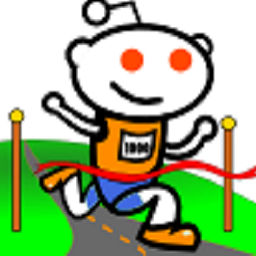
</div>

r/ultrarunning: "sometimes a marathon isn't far enough"

r/AdvancedRunning: "It's a mindset"



## Problem statement

I am a newbie to the marathon scene, having completed my first virtual StanChart marathon when the country was locked down during Covid-19 last year. I am itching to do my first ultramarathon (defined as any run beyond 42.195km) and have prepared a series of posts to ask running veterans for training advice. I found that the most popular running community to be r/running with 1.5 million members but most of their posts are for running newbies or people looking to cover their first 10k / 10mile, or their first marathon. The two next most popular reddit communities for more advanced types of running would be r\ultrarunning and r\AdvancedRunning. These are some of their attributes:

|subreddit|Date Created|Number of Members|Members Online (at time of checking)|
|---------|------------|-----------------|------------------------------------|
|r\ultrarunning|Feb 4, 2012|45,900|31 (on 27 Sep, 1700h, SG time)|
|r\AdvancedRunning|Oct 31, 2011|142,000|169 (on 27 Sep, 1700h, SG time)|

A quick scan of their recent posts is not very helpful. Both communities have a lot of posts about how to train for 50k and beyond, as well as other miscellaneous items such as race reports. It is time to deploy my data science skills to come up with an algorithm to decide which running community most suited for my questions...

## Executive summary

Describe both subreddits, e.g. # of users, activity frequency

## Import Libraries

In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_venn import venn2
import seaborn as sns

# Import time- and API- related libraries
import time, requests
from datetime import datetime

# Import warnings to remove flags when project is complete
import warnings
warnings.filterwarnings('ignore')

# Import pre-processing libraries
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
import re
# from wordcloud import WordCloud ## Can't seem to install wordcloud, remember to try again at end of project
# from PIL import Image

# Import vectorizing libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Import modelling-related libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    ExtraTreesClassifier)
from sklearn.metrics import (
    confusion_matrix, 
    plot_confusion_matrix, 
    plot_roc_curve,
    roc_auc_score
)

# Import boosting libraries learnt after project was mostly done
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# Set viewing parameters
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

## Scrap reddit

### Create scrapper function

In [2]:
# Create scrapper function

def scrape_subreddit(subreddit, numberofposts = 1_000):
    # Define pushshift's base URL
    url = 'https://api.pushshift.io/reddit/search/submission'
    
    # Define columns i want to keep
    to_keep = ['subreddit','author','title','selftext','created_utc']
    
    # Set current time in UTC timestamp format
    df_time = int(datetime.timestamp(datetime.utcnow()))
    
    # Create empty dataframe for concating loop later on
    df = pd.DataFrame(columns = to_keep)
    df_length = len(df)
    
    # Create dataframe of posts
    while df_length < numberofposts:

        # Set params
        params = {
            'subreddit' : subreddit,
            'size' : 100,
            'before' : df_time
        }

        # Get request from pushshift.io, return error message if it is not from 200 series
#         res = requests.get(url, params)
        try:
            res = requests.get(url, params)

            # Return error message if it's not 2xx
            if (res.status_code // 100) != 2:
                return "Hey dude, error! Unexpected response {}".format(res)

        except res.exceptions.RequestException as e:
            # A serious problem happened, like an SSLError or InvalidURL
            return "Yo, this is a very terrible error: {}".format(e)
        
        
        # Concat relevant .json data into dataframe
        df = pd.concat([
            df,
            pd.DataFrame(res.json()['data'])[to_keep]
        ], 
            axis = 0
        )
        
        # Clean data
        ##  1. drop empty posts
        df = df.loc[
            ((df['selftext'] != '') & (df['selftext'] != '[removed]')),
            :
        ].sort_values('created_utc', ascending = False)
        ##  2. drop duplicates by author with same text
        df = df.drop_duplicates(subset=['selftext', 'author'], keep = 'first').reset_index(drop=True)
        ##  3. drop nulls, especially true for selftext column
        df.dropna(inplace = True)
        
        # Find earliest-dated post in dataframe
        df_time = df['created_utc'].min()
#         print(f"min time is {df_time}.")
        
        # Find current length of dataframe (
        df_length = len(df)
        print(f"df for r\\{subreddit} has {df_length} posts now.")
       
        # Be a good citizen of scrapping world, don't overload pushshift server 
        # Sleep between 1-3 seconds
        time.sleep(1 + np.random.rand() * 2)
        
    return df[:numberofposts]
    
    

Describe scrapper function:
- Arguments to feed in are (subreddit, numberofposts)
    - "subreddit" is the name of the target subreddit
    - "numberofposts" is the number of good-quality reddit posts to extract (default value is set at 1_000)
- Set size at 100 for each request for posts
- Dropping bad-quality posts:
    - I notice about 20% of the posts are pictures or videos of people running, with nothing written, i.e. '' in the 'selftext', so those are dropped
    - There are a small number of np.nan posts, those are removed
    - A number of posts seem to be advertisements, they are labeled "[removed]" in the 'selftext' columns, so those are dropped
    - I remove reposts by the same author just in case they are posted more than once
- I set a random sleep time of between 1 to 2 seconds to avoid getting blacklisted by server for repeat requests

### Scrap scrap scrap

> Do not run this section to save time. Jump straight to Section 5.1 to download saved .csv files. Typically takes about 3-10 minutes for me to run, depending on internet connection

To extract 1,500 good-quality posts from each subreddit community. Chosen subreddits are:
- r\ultrarunning
- r\AdvancedRunning

In [3]:
%%time

# set scrape parameters
subreddit1 = 'ultrarunning'
subreddit2 = 'AdvancedRunning'
posts = 2_500


# Do not run this section to save time
# Typically takes about >10 minutes for me to run, depending on internet connection
# df1 = scrape_subreddit(subreddit1, posts)
# df2 = scrape_subreddit(subreddit2, posts)

# Load the files below to save time
df1 = pd.read_csv('../data/df1.csv')
df2 = pd.read_csv('../data/df2.csv')

CPU times: user 51.4 ms, sys: 9.7 ms, total: 61.1 ms
Wall time: 159 ms


In [4]:
df1

,subreddit,author,title,selftext,created_utc
0,ultrarunning,WitheredBallSack,Signed up for an ultra 6 weeks away - help!!,I am a casual runner but a buddy of mine pushe...,1632745618
1,ultrarunning,ck425,Weight loss three weeks out from first Ultra?,"Hi All,\n\nApologies I wrote this and added a ...",1632732641
2,ultrarunning,EramSumEro,White long-sleeved shirts for sun protection?,Running javelina jundred at the end of October...,1632708998
3,ultrarunning,jparker74,Adv Skin 12 Chest Lacing,Has anyone tried lacing it across your chest m...,1632699223
4,ultrarunning,WholeAwareness4,Running Distance After Major Injuries,"Hi Folks,\nI’m sure this question comes up fro...",1632688783
...,...,...,...,...,...
2495,ultrarunning,Teroc,How much racing is too much racing?,"Hello everyone,\n\nI'm planning my races for n...",1570694453
2496,ultrarunning,vonralls,Anyone running the Walking Tall 50K next weeke...,I'll be running the railroad aid station again...,1570639571
2497,ultrarunning,MarsRage,Trekking poles and knee health?,I have my second 50k coming up and I am fairly...,1570628019
2498,ultrarunning,MAP_Content,MAP To Ultra Marathon Running #001,Hello Beautiful Kings and Queens! \n\n\nMy n...,1570580620


In [5]:
df2

,subreddit,author,title,selftext,created_utc
0,AdvancedRunning,beezus_quimby,How to prep the day/night before speedworkout?...,Hi! Longtime lurker firsttime caller. \n\nI am...,1632752356
1,AdvancedRunning,ijonesco,Possible Injury in my knees?,Hello!\n\nIm a high school distance runner and...,1632751911
2,AdvancedRunning,perseverance_coach,Mental Toughness from a Strengths-Based Approach,[Full article: A Strengths-Based Approach to ...,1632749729
3,AdvancedRunning,jddawg88,Sore upper back on longer runs?,Some context: I’ve been training for my first ...,1632742508
4,AdvancedRunning,calmarfurieux,Berlin Marathon 2021,## Race information\n\n* **What?** Berlin Mara...,1632740002
...,...,...,...,...,...
2495,AdvancedRunning,CarlSag,Does the Maffetone Method really prescribe all...,I picked up Phil Maffetone’s book “The Big Boo...,1608083446
2496,AdvancedRunning,not_alemur,What worked for you to treat your plantar fasc...,This is a first for me and I’m having trouble ...,1608082082
2497,AdvancedRunning,zps77,Those who trained through pregnancy - tips &am...,"Hey all,\n\nThe wife is just over 7 weeks preg...",1608081836
2498,AdvancedRunning,stillslammed,Questions about collegiate running as a grad s...,I'm almost done my undergrad and I'm looking a...,1608074462


### Save files to .csv

In [6]:
# Check that all nan posts are removed by my scrapper
print(f"# of Nulls for df1 \n {df1.isnull().sum()}")
print()
print(f"# of Nulls for df2 \n {df2.isnull().sum()}")

# of Nulls for df1 
 subreddit      0
author         0
title          0
selftext       0
created_utc    0
dtype: int64

# of Nulls for df2 
 subreddit      0
author         0
title          0
selftext       0
created_utc    0
dtype: int64


In [7]:
# Check files for empty posts or that are '[removed]' by reddit

In [8]:
df1.loc[((df1.selftext == '[removed]') | (df1.selftext == '')), :]

,subreddit,author,title,selftext,created_utc


In [9]:
df2.loc[((df1.selftext == '[removed]') | (df2.selftext == '')), :]

,subreddit,author,title,selftext,created_utc


In [10]:
# Check that reposts by authors are removed by my scrapper
df1.duplicated().sum(), df2.duplicated().sum()

(0, 0)

In [11]:
# Save files
df1.to_csv('../data/df1.csv', index = False)
df2.to_csv('../data/df2.csv', index = False)

## EDA and pre-processing

### Load data

In [12]:
df1 = pd.read_csv('../data/df1.csv')
df2 = pd.read_csv('../data/df2.csv')

In [13]:
df1.shape, df2.shape

((2500, 5), (2500, 5))

### Check authors
The intent is to look for very prolific authors who might post so much to a subreddit community that a classification model might just innocently fit to a very small group of authors' writing style. 

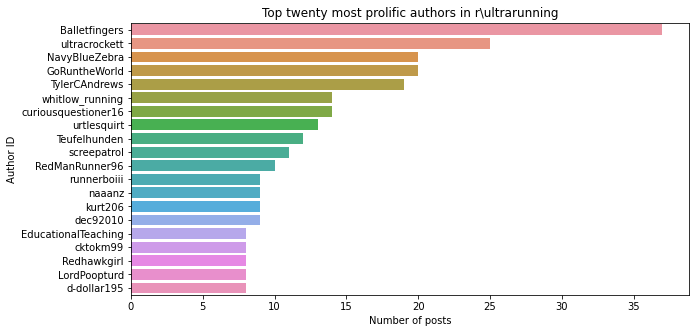

In [14]:
# Rank authors by posts
authors = df1.groupby("author")['selftext'].count().sort_values(ascending = False).head(20)

plt.figure(figsize=(10,5))
ax = sns.barplot(x = authors.values, y = authors.index)
ax.set_title(f"Top twenty most prolific authors in r\\{subreddit1}")
ax.set_xlabel("Number of posts")
ax.set_ylabel("Author ID");

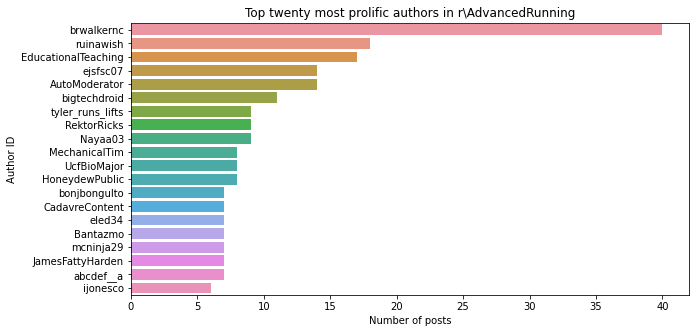

In [15]:
authors = df2.groupby("author")['selftext'].count().sort_values(ascending = False).head(20)

plt.figure(figsize=(10,5))
ax = sns.barplot(x = authors.values, y = authors.index)
ax.set_title(f"Top twenty most prolific authors in r\\{subreddit2}")
ax.set_xlabel("Number of posts")
ax.set_ylabel("Author ID");

It looks like there is no issue with overly-prolific authors on both subreddits. The author with the highest number of posts on r\Ultramarathon is ultracrockett with 25 posts and the author with the highest on r\AdvancedRunning is brwalkernc with 31 posts. They make up <=3% of their sample sets respectively. 

* However, I notice that there is a weird-sounding author called "AutoModerator" on r\AdvancedRunning. Let me look into this author further.

In [16]:
# Check posts written by AutoModerator
pd.set_option('display.max_colwidth', None) #Expand Pandas' column width to show full thread content 
df2[df2['author'] == "AutoModerator"]

,subreddit,author,title,selftext,created_utc
10,AdvancedRunning,AutoModerator,"The Weekly Rundown for September 27, 2021",The Weekly Rundown is the place to talk about your previous week of running! Let's hear all about it!\n\nPost your Strava activities (or whichever platform you use) if you'd like!,1632715271
30,AdvancedRunning,AutoModerator,"Saturday General Discussion/Q&amp;A Thread for September 25, 2021",A place to ask questions that don't need their own thread here or just chat a bit.,1632542472
42,AdvancedRunning,AutoModerator,"The Weekend Update for September 24, 2021","What's everyone up to on this weekend? Racing? Movie date? Playing with Fido? Talk about that here!\n\nAs always, be safe, train smart, and have a great weekend!",1632456074
76,AdvancedRunning,AutoModerator,Tuesday Shoesday,Do you have shoe reviews to share with the community or questions about a pair of shoes? This recurring thread is a central place to get that advice or share your knowledge.,1632240020
281,AdvancedRunning,AutoModerator,Monthly Reflections for August 2021,"Alas, a new month is on its way and thus we take a moment of solidarity to reflect on what was...\n\n**The good stuff:**\n\n**Monthly Questions:**\n\n* Miles this month. What are your goals for miles in 2021?\n* What did you learn this month? Any reflections?\n* What would you like to do moving forward in the next month? Any goals?\n* What races do you have on your calendar in the next few months?\n* What was your favorite run this past month?\n\n**Race Reports**\n\nDid you run a small race that you didn't want to post a full report for? Feel free to toss it here.\n\n**Photos**\n\nDo you have a photo to share from the month of literally whatever, this is the place friends!",1630382421
603,AdvancedRunning,AutoModerator,Monthly Reflections for August 2021,"Alas, a new month is on its way and thus we take a moment of solidarity to reflect on what was...\n\n**The good stuff:**\n\n**Monthly Questions:**\n\n* Miles this month. What are your goals for miles in 2021?\n\n* What did you learn this month? Any reflections?\n\n* What would you like to do moving forward in the next month? Any goals?\n\n* What races do you have on your calendar in the next few months?\n\n* What was your favorite run this past month?\n\n**Race Reports**\n\nDid you run a small race that you didn't want to post a full report for? Feel free to toss it here.\n\n**Photos**\n\nDo you have a photo to share from the month of literally whatever, this is the place friends!",1627704078
1860,AdvancedRunning,AutoModerator,Monthly Reflections for February 2021,"Alas, a new month is on its way and thus we take a moment of solidarity to reflect on what was...\n\n**The good stuff:**\n\n**Monthly Questions:**\n\n* Miles this month. What are your goals for miles in 2020?\n\n* What did you learn this month? Any reflections?\n\n* What would you like to do moving forward in the next month? Any goals?\n\n* What races do you have on your calendar in the next few months?\n\n* What was your favorite run this past month?\n\n**Race Reports**\n\nDid you run a small race that you didn't want to post a full report for? Feel free to toss it here.\n\n**Photos**\n\nDo you have a photo to share from the month of literally whatever, this is the place friends!",1614488477
2367,AdvancedRunning,AutoModerator,"The Tuesday General Discussion Thread for December 29, 2020","It's Tuesday again, thus we give you the Tuesday General Discussion thread, feel free to ask questions that don't need their own thread here or just chat a bit.",1609218071
2388,AdvancedRunning,AutoModerator,"General Discussion for the week of December 27, 2020","Please use this thread to discuss whatever is on your mind be it running, life, or whatever you fancy.",1609045274
2409,AdvancedRunning,AutoModerator,"The Weekly Update for December 25, 2020","What's everyone up to on this weekend? Racing? Movie date? Playing with Fido? Talk about that here!\n\nAs always, be safe, train smart, 

It looks like 'AutoModerator' is a bot that automatically generates posts to keep readers interested or engaged on events happening in the running world. I shall drop its posts since we are interested in analysing human-generated posts only. These posts make up <0.5% of the sample set.

In [17]:
# Drop AutoModerator
df1 = df1[df1['author'] != "AutoModerator"]
df2 = df2[df2['author'] != "AutoModerator"]

In [18]:
# Check
df1[df1['author'] == "AutoModerator"], df2[df2['author'] == "AutoModerator"]

(Empty DataFrame
 Columns: [subreddit, author, title, selftext, created_utc]
 Index: [],
 Empty DataFrame
 Columns: [subreddit, author, title, selftext, created_utc]
 Index: [])

### Check dates

In [19]:
# Check time range of df1
print(f"The start date of df1 is {datetime.fromtimestamp(df1.created_utc.min())}.")
print(f"The end date of df1 is {datetime.fromtimestamp(df1.created_utc.max())}.")

The start date of df1 is 2019-10-09 03:11:27.
The end date of df1 is 2021-09-27 20:26:58.


In [20]:
# Check time range of df2
print(f"The start date of df2 is {datetime.fromtimestamp(df2.created_utc.min())}.")
print(f"The end date of df2 is {datetime.fromtimestamp(df2.created_utc.max())}.")

The start date of df2 is 2020-12-16 02:32:49.
The end date of df2 is 2021-09-27 22:19:16.


r\Ultramarathon has a wider date range than r\AdvancedRunning. Let's check the distribution of their post dates.

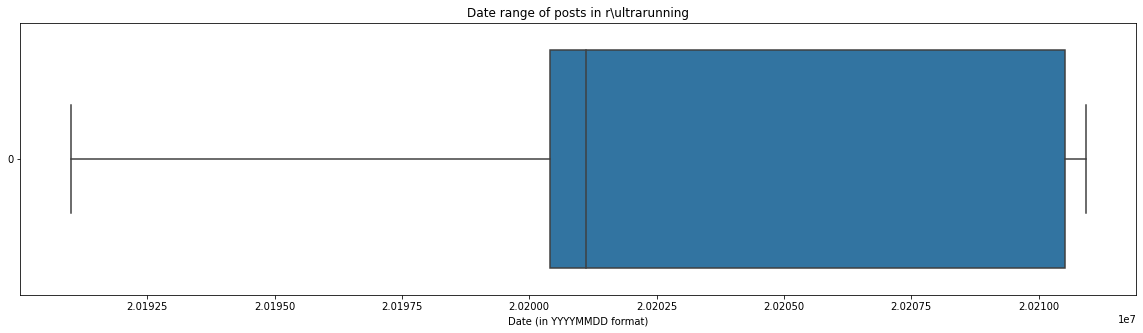

In [21]:
# Convert UTC time to yyyymmdd format, and plot date range
plt.figure(figsize = (20,5))

ax = sns.boxplot(
    data= [int(datetime.utcfromtimestamp(x).strftime("%Y%m%d")) for x in df1.created_utc],
    orient = "h",
)

ax.set_title(f"Date range of posts in r\\{subreddit1}")
ax.set_xlabel("Date (in YYYYMMDD format)");

While r\Ultramarathon has a 5 year date range for its posts, most of the posts are concentrated in the 2019-2021 range, so they are still quite recent. The 2019-2021 posts are also quite uniformly distributed around the median post. 

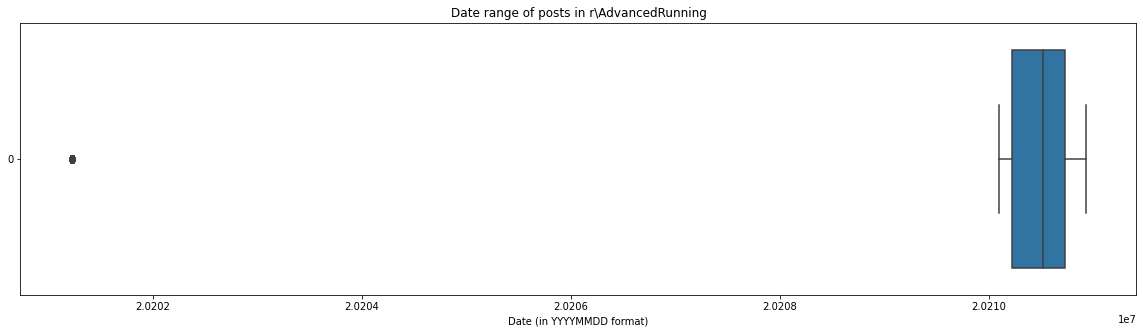

In [22]:
# Convert UTC time to yyyymmdd format, and plot date range
plt.figure(figsize = (20,5))

ax = sns.boxplot(
    data= [int(datetime.utcfromtimestamp(x).strftime("%Y%m%d")) for x in df2.created_utc],
    orient = "h",
)

ax.set_title(f"Date range of posts in r\\{subreddit2}")
ax.set_xlabel("Date (in YYYYMMDD format)");

No surprises here, most of r\AdvancedRunning's posts are between June and mid-August of this year. 

r\AdvancedRunning clearly seems to be a more popular or active subreddit. However, less active does not mean worse, as the quality of posts may be more important. We shall move on to check on post characteristics.

### Check low word count posts

In [23]:
df = pd.concat([df1, df2], axis = 0).reset_index(drop=True)
df['word_count'] = df['selftext'].map(lambda x: len(x.split()))

In [24]:
df.groupby('subreddit').agg({'word_count': ['min', 'median', 'mean', 'max']})

word_count                         
                       min median        mean   max
subreddit                                          
AdvancedRunning          1  121.5  223.104586  5406
ultrarunning             1   90.0  134.168800  2663

The median post in r\Ultramarathon is slightly shorter than r\AdvancedRunning. Same for mean word count. 

For both subbreddits, the mean word count is higher than median word count, so it suggests that some writers in the latter community write very long posts!

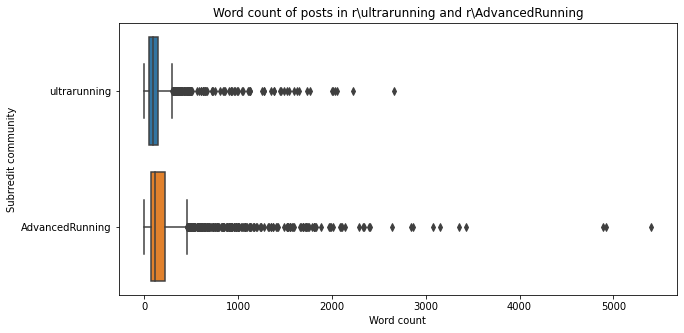

In [25]:
plt.figure(figsize = (10,5))
ax = sns.boxplot(data = df, 
                 x = "word_count", 
                 y = "subreddit",
                 orient = "h",
);

ax.set_title(f"Word count of posts in r\\{subreddit1} and r\\{subreddit2}")
ax.set_xlabel("Word count");
ax.set_ylabel("Subrredit community");

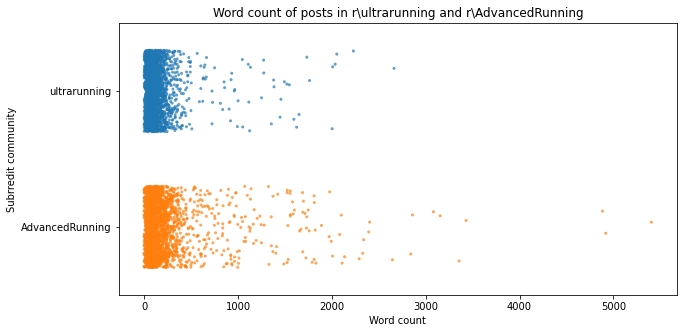

In [26]:
plt.figure(figsize = (10,5))
ax = sns.stripplot(data = df,
                   x = "word_count", 
                   y = "subreddit",
                   size = 3,
                   alpha = 0.7,
                   jitter = 0.3
                   
                
);

ax.set_title(f"Word count of posts in r\\{subreddit1} and r\\{subreddit2}")
ax.set_xlabel("Word count");
ax.set_ylabel("Subrredit community");

Box plots and strip plots suggest that writers in r\AdvancedRunning write more than those in r\Ultramarathon, with quite a number of them writing essay-length posts of over 5000 words!!


In the groupby table above, I notice that the minimum number of words is 1. Let's analyse posts with low word counts to see if they are useful for my model. I start with a random sample of posts with 5 words or less.

In [27]:
# Count the number of posts with low word count
for i in range(1,6):
    print(f"There are {len(df[df['word_count'] == i])} posts of word count length = {i}.")

There are 36 posts of word count length = 1.
There are 6 posts of word count length = 2.
There are 2 posts of word count length = 3.
There are 9 posts of word count length = 4.
There are 5 posts of word count length = 5.


In [28]:
# Increase column width to view post contents
pd.set_option('display.max_colwidth', None)

In [29]:
# Sample posts with low word counts to see if they are useful
df.loc[df['word_count'] <= 5, :].sample(5)

,subreddit,author,title,selftext,created_utc,word_count
3415,AdvancedRunning,ChiefFerg,Mo Farah Targeting sub 27.30 NOW,https://youtu.be/LH7tVkEywyw,1624654133,1
3503,AdvancedRunning,georgie_babbitt,Gene Dykes breaks 50k 70+ age group world record - 3:56:43,https://www.strava.com/activities/5468747243,1623693715,1
2878,AdvancedRunning,cormstorm123,Seth James Demoor has a 15min lead in the Pikes Peak Marathon right now,Assent in 2:06:44,1629646068,3
3685,AdvancedRunning,captainolek,How to find the perfect fueling? I tried a glucose monitoring sensor.,https://youtu.be/nqKxedxUz7w,1621948982,1
3867,AdvancedRunning,1deepthink,Boston Applicants acceptances are in! Good luck everyone!,[https://twitter.com/bostonmarathon/status/1389651973360730120](https://twitter.com/bostonmarathon/status/1389651973360730120),1620156618,1


It looks like vast majority of low word count posts are urls. They will be removed in Section 5.6 ([remove_URLs](#remove_url)).

Some are obvious spams, such as "love stream is at:..." or "die die dieee". These will be handled in Section 5.7 ([delete_low_word_count_posts](#delete_low_word_count_posts)). Some are post of run timings, which may be relevant or useful information to readers and will be kept.

<a id='word_count_1'></a>
### Total word count

In [30]:
# Count starting number of words
print(f"Before pre-processing, I start with {df['word_count'].sum()} words in my dataset.")

Before pre-processing, I start with 890060 words in my dataset.


<a id='remove_url'></a>
### Remove URLs

In [31]:
# Remove all text with "http" in it
df['cleaned_1'] = df['selftext'].map(
    lambda x: re.sub(r'http\S+', '', x)
)

In [32]:
# Sample to check rows with URLs orginally
df.loc[['http' in x for x in df['selftext']],['selftext','cleaned_1']].sample(2)

,selftext,cleaned_1
1398,https://youtu.be/ZsFzKXHoy0Q\n\nhttps://youtu.be/Rv2-oQOWhT0\n\nI know it looks like I'm trying to have good form for the video but this is me trying to be relaxed. To me I look very stiff but I don't know how to fix that,\n\n\n\nI know it looks like I'm trying to have good form for the video but this is me trying to be relaxed. To me I look very stiff but I don't know how to fix that
1815,"Hey fellow runners and thanks to you all for the valuable insights over the years!\n\nAfter some hard work and elbow grease, I'm ready to share what I've been working on. It's a new website with the vision of adding every minimalist/barefoot shoe brand I could find on the internet 👟\n\nI've often found it difficult to find brands by the different types of shoes/boots/sandals they make, so the website includes filters to help you find the brands that make what you're looking for.\n\nSo far, you can filter by types of shoes, activities (casual, running, hiking etc), sex and key features.\n\nI'm at the start of my journey in learning how to build websites and I've *tried* to make it at simple to use as possible. I hope it provides at least some value back to you bunch of awesome people.\n\nThis is just the newest version and I'd love to hear what you guys think. Even more importantly, I'd love to hear what **you** would like to see to make it even more valuable for you 🙂\n\nCheck it out here - [Minimal-list](https://link.minimal-list.org/3vf)\n\nHappy to answer any questions!\n\nThanks, Adam","Hey fellow runners and thanks to you all for the valuable insights over the years!\n\nAfter some hard work and elbow grease, I'm ready to share what I've been working on. It's a new website with the vision of adding every minimalist/barefoot shoe brand I could find on the internet 👟\n\nI've often found it difficult to find brands by the different types of shoes/boots/sandals they make, so the website includes filters to help you find the brands that make what you're looking for.\n\nSo far, you can filter by types of shoes, activities (casual, running, hiking etc), sex and key features.\n\nI'm at the start of my journey in learning how to build websites and I've *tried* to make it at simple to use as possible. I hope it provides at least some value back to you bunch of awesome people.\n\nThis is just the newest version and I'd love to hear what you guys think. Even more importantly, I'd love to hear what **you** would like to see to make it even more valuable for you 🙂\n\nCheck it out here - [Minimal-list](\n\nHappy to answer any questions!\n\nThanks, Adam"


In [33]:
# Refresh word count column
#   and check posts with low word count again
df['word_count'] = df['cleaned_1'].map(lambda x: len(x.split()))

for i in range(1,6):
    print(f"There are {len(df[df['word_count'] == i])} posts of word count length = {i}.")

There are 23 posts of word count length = 1.
There are 4 posts of word count length = 2.
There are 2 posts of word count length = 3.
There are 11 posts of word count length = 4.
There are 4 posts of word count length = 5.


<a id='delete_low_word_count_posts'></a>
### Delete low word count posts

There are just a handful of posts with 2 words or less. These might be the remnants of those posts that mainly most links to videos or other websites. Let's check them out.

In [34]:
# Sample posts with 2 word counts or less
df.loc[df['word_count'] <= 2, ['author', 'cleaned_1']].sample(10)

,author,cleaned_1
20,MuiMui888,
2885,[deleted],[deleted]
882,bullmarket2020,[
4074,TaiKeiDai,[effacé]
296,lvcaswiman,
3685,captainolek,
3434,qcassidyy,Be honest.
2969,Technical-Pop-2504,Thank you
200,[deleted],[deleted]
3867,1deepthink,[


To delete all of the above posts, they are not written in proper English and won't contribute in training my model in predicting posts.

In [35]:
# Delete cleaned posts with 2 words or less
df = df.loc[df['word_count'] >2,:]
# Check
df.shape

(4944, 7)

In [36]:
# Check posts with 3 words
df.loc[df['word_count'] == 3, ['author', 'title', 'cleaned_1']]

,author,title,cleaned_1
2878,cormstorm123,Seth James Demoor has a 15min lead in the Pikes Peak Marathon right now,Assent in 2:06:44
4620,runnerd6,Top American ultra runners currently competing for the 100k world record at the Hoka Project Carbon X2,Watch here: [


In [37]:
# Check posts with 4 words
df.loc[df['word_count'] == 4, ['subreddit', 'title','cleaned_1']]

,subreddit,title,cleaned_1
459,ultrarunning,The Top 10 UK Ultra’s,In one guys opinion! \n\n
669,ultrarunning,Thoughts on ultrarunners using cannabis for recovery or just in general during training blocks?,Just curious about this.
1961,ultrarunning,2020 Barkley Marathons Cancelled,Jamil Coury announced it.
2018,ultrarunning,Livetracking Walsmley at the trials,[click here](\n\nLet’s goooo!
2452,ultrarunning,The game changers on Netflix,Thoughts about the documentary.
2858,AdvancedRunning,What are some unwritten rules of running?,Common or uncommon ones
2948,AdvancedRunning,Ask me a question and edit it to make my answer look bad.,keep it runing related!
3106,AdvancedRunning,Olympics Men’s 10000m Race Results (SPOILERS),Discuss the race here
3654,AdvancedRunning,Hobbs Kessler just ran 3:34.36.....faster than the NCAA record and still in High School,"Insane, just insane\n\nDiscuss"
3836,AdvancedRunning,What’s your mantra?,Looking to “borrow” some.


In [38]:
# Check posts with 5 words
df.loc[df['word_count'] == 5, ['subreddit','author','title','cleaned_1']]

,subreddit,author,title,cleaned_1
948,ultrarunning,adriannairda,Is someone here doing the 4-4-48 challenge?,Any recommendations? Much appreciate it!
1413,ultrarunning,exiveres,Racing?,Are any states allowing ultras?
2526,AdvancedRunning,birdsneedshoes,Berlin,Is it screened online anywhere?
4184,AdvancedRunning,jansam18,Isn't it weird that it is that steady?,"looks like too much ""aesthetic""\n\n"


After deleting posts with 2 or less words, I analyse posts with 3-5 words. 

It is clear that the longer the posts, the more relevant they are to running:
* Those with 3 words are irrelevant and will be killed off.
* Those with 4 words are less relevant so it should be okay killing it. For example, one has a message called "love stream is at:" while another author named mcdishy posted the same message on both subreddits giving his opinion of the top 10 ultramarathons in the UK.
* The posts with 5 words are somewhat relevant to running, so I shall keep them. 


In [39]:
# Remove posts with 3 and 4 words, retain only posts with 5 words and above

df = df.loc[df['word_count'] >= 5,:].reset_index(drop=True)
# Check
df.shape

(4931, 7)

In [40]:
4931/5000 - 1

-0.013800000000000034

A total of about 70 mostly-irrelevant posts (<2% of the original posts) are removed.

### Remove special characters

In [41]:
# Look at cleaned samples again
df[['subreddit','title','cleaned_1']].sample(5)

,subreddit,title,cleaned_1
4064,AdvancedRunning,Follow Up 5x1km 5k Training Workout Review,"Reposting under ""General Discussion"" as directed by mods.\n\nI made the post linked below about a week ago covering the 3x1mi workout. As mentioned, I am training for a sub 16 5k. I figured I would post a follow up as requested by some.\n\n\n\nToday at lunch I did 5x1km w/ 90s rest on a road loop. The workout felt great again, even though the temperature recently jumped up from mid 30°F to mid 70°F in Wisconsin in the span of a couple days. I felt quite controlled and comfortable such that I was able to cut it down.\n\nSplits were (w/ 90s rest):\n3:07, 3:07, 3:05, 3:05, 3:02\n\nTotal time of 15:26.\nAverage pace of ~4:59/mi.\n\nI'm feeling good about breaking 16 mins in the 5k given the more standard shorter rest for this one after the longer rest in that first early mile repeat workout and knowing that I felt good significantly under 3:12/km for every rep and cutting it down quite a bit.\n\nAs mentioned in the previous post, I am doing about 50-60 mi/week and have no coach or training plan. I've been almost entirely running solo since covid started, so I'm quite pleased with my fitness and ability to hit these workouts solo."
2003,ultrarunning,Anybody have one of the Patagonia hydration packs? How do you like it?,"Received a Patagonia gift card a bit a go and am trying to decide what to use it on. I already have the houdini wind breaker, but their vests look cool. Would primarily be looking at the 8L since I'm looking for a vest I can take out for like 8 hours on some longer runs this summer. Any reviews or other gift card suggestions appreciated."
1646,ultrarunning,Who were the big names in ultrarunning before Scott Jurek and Ann Trason?,"I graduated high school in 2010 and while it took me a few good years to get into running ultras, I knew of Scott Jurek and Ann Trason from my parent's old Runner's World magazine issues, and a couple books I was given as gifts. Before they came, who were the top runners in the ultra scene? I know almost zero history before their time, as if ultrarunning just ""began"" in the 90's.\n\n\n\nWho can tell me some other names I should be familiar with?"
3101,AdvancedRunning,Do shoe companies still make flats for road racing? (5-10K),"TLDR/bonus questions: if they do still make flats, what are some flats that are still being made? If not, what shoes do you use for races?\n\nSo the past few years, I have been racing/time trialing in the New Balance Hanzo S. I like the feel of them, they have amazing durability, I just prefer to continue in something similar. However, the local running stores around me do not sell anything like that. It is either shoes I would wear specifically for training or carbon plated (I have nothing explicitly against carbon plating, just not my preference). The closest one what I’m looking for I have seen around me is the Brooks Hyperion Tempo. Would these be decent shoes for racing?"
665,ultrarunning,Why are there no self supported ultramarathon races?,"I spent a few days at Cocodona last weekend and while the race was absolutely incredible, I found the cost of entry quite deterring. It got me thinking about some of the ultra-distance races in cycling, like the Tour Divide, or GB Duro, where there is technically a race happening, but really it's just people racing from one location to the other with no support. We have FKT's in ultrarunning, but I've never heard of a large group of people racing the PCT, for example, or some other long trail in self supported fashion. Am I the only one that thinks such an endeavour would be awesome? \n\nFurthermore, I wonder what the legal implications are? As long as there are no crews and aid stations, can you even legally organise an event that involves people going through wilderness areas? Even if it's just like 15 people who were invited via Facebook? You can backpack with a group of friends, so at what point is it not allowed? \n\nEither wa

Ran through a number of samples. Manually remove "\n", "\\" , "[]", "()", "|", "-", "&amp;#x200B". Because these subreddits are running-related, it is probably not a good idea to remove numbers as they are usually related to distances or timings. I will probably submitting numbers in my own posts to the subreddits too!

I also notice a lot of "ultras" and "ultramarathons" mentioned on both subreddits, so mental reminder to myself to include them as stop words.

In [42]:
# Replace specials characters
# df['cleaned_2'] = df['cleaned_1'].map(
#     lambda x: re.sub(r'[\n\\\[\]\(\)\|\-]', ' ', x)
# )

# Remove the %ampersand term
df['cleaned_2'] = df['cleaned_1'].map(
    lambda x: x.replace('&amp;#x200B;', ' ') 
)

# Extract words only    
df['cleaned_2'] = df['cleaned_2'].map(
    lambda x: re.sub('[^a-zA-Z]', ' ', x)
)


In [43]:
# Check for removal of special characters
df[['cleaned_1','cleaned_2']].sample(5)

,cleaned_1,cleaned_2
289,"Hey all, \n \nI know the zero drop question gets asked a lot and the answer is usually Altra. \n \nHowever I’ve had 3 pairs fall apart after less than 100 miles (and 2 of those were less than 50). A pair of Lone Peaks, a pair of TIMP 2s, and this morning a pair of Riveras. It’s all stuff that’s quality control issues and they replace them, but I’m tired of having to mail them back or huff it to the nearest REI (I live in the middle of nowhere). \n \nSo all that said….OTHER THAN Altra, what zero drop road and trail shoes do y’all recommend?",Hey all I know the zero drop question gets asked a lot and the answer is usually Altra However I ve had pairs fall apart after less than miles and of those were less than A pair of Lone Peaks a pair of TIMP s and this morning a pair of Riveras It s all stuff that s quality control issues and they replace them but I m tired of having to mail them back or huff it to the nearest REI I live in the middle of nowhere So all that said OTHER THAN Altra what zero drop road and trail shoes do y all recommend
4873,"Hello,\nI'm 20 with a current 10k PB of 39:00 which was completed during a 10-mile race so I could run quicker but was wondering if it would be possible to run a sub 37 in 3 months? I'm looking to follow the advanced 10k training plan here: \nI usually run 2-3 hard sessions a week (including one hill session) as well as 3 easy runs\nLooking for training advice.\nCurrent PBs:\n1 mile = 5:10, 5k = 18:13, 10k = 39:02, 10 mile = 63:43",Hello I m with a current k PB of which was completed during a mile race so I could run quicker but was wondering if it would be possible to run a sub in months I m looking to follow the advanced k training plan here I usually run hard sessions a week including one hill session as well as easy runs Looking for training advice Current PBs mile k k mile
796,"Does anyone have experience with Scarpa trail running shoes? I'm specifically looking at the spin ultra but open to other suggestions. Wondering mostly about durability, comfort, and responsiveness as well as how they compare (fit) to other brands. I usually wear topo trail shoes and am worried the Scarpa's will feel too tight through the toe box",Does anyone have experience with Scarpa trail running shoes I m specifically looking at the spin ultra but open to other suggestions Wondering mostly about durability comfort and responsiveness as well as how they compare fit to other brands I usually wear topo trail shoes and am worried the Scarpa s will feel too tight through the toe box
2594,"30M, 5ft9, 165lb with an original planned target goal of 3:05.\n\nI'm running Chester Marathon on the 3rd October after coming to the end of Pfitz 12/55. I'd planned to follow the 18/55 plan but had been running around 35mpw prior to starting the plan and ran two trail races (a 20M with 3k feet of elevation and a 27m with 4k feet of elevation) so I opted for the shorter plan to take a few weeks to recover. I don't feel I've missed out too much by going for the shorter plan.\n\nThe training block has gone very well - I've only missed two runs from the schedule due to family commitments (an 11m medium-long run and a 4m recovery run). I've also hit or exceeded all of my target paces during speedwork and the MP long runs.\n\nI ran a track 10K TT 2 weeks ago in 38:34 (Mile Splits: 6:20, 6:15, 6:18, 6:15, 5:59, 0.2@5:37). The last 1.2M suggests I might have had a bit more in the tank? Would like to think i'd break 38 minutes in an actual race.\n\nIs sub-3 on the cards? I don't want to risk blowing up and missing my 3:05 goal but if sub-3 is a real possibility (especially with Chester being such a flat course) then I feel I should take the opportunity to go for it.",M ft lb with an original planned target goal of I m running Chester Marathon on the rd October after coming to the end of Pfitz I d planned to follow the plan but had been running around mpw prior to starting the plan and ran two trail races a M w

A few rounds of sampling shows that the cleaning looks fine.

### Check sentiment

I am curious to find out the general sentiment of writers in these two subreddits, want to see if there is a discernible difference between each community. I use the VADER (Valence Aware Dictionary and sEntiment Reasoner) lexicon to analyze the sentiments of our posts.

In [44]:
# Create sentiment column
sent = SentimentIntensityAnalyzer()
df['sentiment'] = df['cleaned_2'].map(lambda x: sent.polarity_scores(x)['compound'])

In [45]:
# Check sentiment
df.groupby('subreddit').agg({'sentiment': ['min', 'median', 'mean', 'max']})

sentiment                           
                      min   median      mean     max
subreddit                                           
AdvancedRunning   -0.9940  0.77830  0.512624  1.0000
ultrarunning      -0.9969  0.69195  0.467574  0.9998

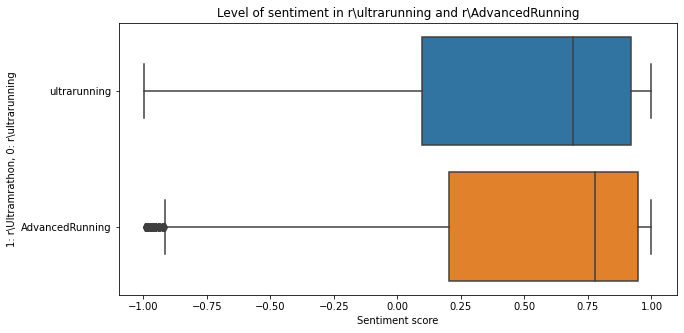

In [46]:
plt.figure(figsize = (10,5))
ax = sns.boxplot(data = df, 
                 x = "sentiment", 
                 y = "subreddit",
                 orient = "h",
);

ax.set_title(f"Level of sentiment in r\\{subreddit1} and r\\{subreddit2}")
ax.set_xlabel("Sentiment score");
ax.set_ylabel("1: r\\Ultramrathon, 0: r\\ultrarunning");

The median runner-author seems to be a very positive person, with a score of 0.69 and 0.76 for r\Ultramarathon and r\AdvancedRunning respectively! The mean score is much lower for both communities, dragged down by a number of neutral and negative posts. I cannot discern a material difference between posts in the two subreddit communities based on VADER sentiment analysis.

### Tokenize words

I shall make all words lower case and split by blank spaces.

In [47]:
# Tokenizing...
df['cleaned_3'] = df['cleaned_2'].map(lambda x: x.lower().split())
# Check
df[['cleaned_1','cleaned_2','cleaned_3']].sample(3)

,cleaned_1,cleaned_2,cleaned_3
4559,"Anyone have this shoe? I’ve been running in it the past two weeks in various types of runs and personally they are HORRIBLE!\n\nFeels like a completely different shoe in every way possible than the previous SL20. I bought the .2s on a whim cause I was afraid they would sell out. There was no indication or big announcement from adidas about the .2s\n\nWorried now cause the SL20s have been my all time favorite shoe. So versatile, light and fast. Considering just stocking up and buying in bulk the last few pairs I can if they decide to stray further away in all things I felt made the SL20s great.\n\nDoes anyone know if the SL20.2 is the official successor of the SL20s? Cause I can’t find much buzz about it, which is odd considering the SL20s were such a favored shoe by everyone.",Anyone have this shoe I ve been running in it the past two weeks in various types of runs and personally they are HORRIBLE Feels like a completely different shoe in every way possible than the previous SL I bought the s on a whim cause I was afraid they would sell out There was no indication or big announcement from adidas about the s Worried now cause the SL s have been my all time favorite shoe So versatile light and fast Considering just stocking up and buying in bulk the last few pairs I can if they decide to stray further away in all things I felt made the SL s great Does anyone know if the SL is the official successor of the SL s Cause I can t find much buzz about it which is odd considering the SL s were such a favored shoe by everyone,"[anyone, have, this, shoe, i, ve, been, running, in, it, the, past, two, weeks, in, various, types, of, runs, and, personally, they, are, horrible, feels, like, a, completely, different, shoe, in, every, way, possible, than, the, previous, sl, i, bought, the, s, on, a, whim, cause, i, was, afraid, they, would, sell, out, there, was, no, indication, or, big, announcement, from, adidas, about, the, s, worried, now, cause, the, sl, s, have, been, my, all, time, favorite, shoe, so, versatile, light, and, fast, considering, just, stocking, up, and, buying, in, bulk, the, last, few, pairs, i, can, if, they, decide, ...]"
1061,Are there any Serpents Trail 50k veterans (UK) here that I could pick on for some knowledge and experience. It'll be my first ultra and just have a few general queries about the course and setup,Are there any Serpents Trail k veterans UK here that I could pick on for some knowledge and experience It ll be my first ultra and just have a few general queries about the course and setup,"[are, there, any, serpents, trail, k, veterans, uk, here, that, i, could, pick, on, for, some, knowledge, and, experience, it, ll, be, my, first, ultra, and, just, have, a, few, general, queries, about, the, course, and, setup]"
2842,"Hi! Just getting into run coaching and wondering if there are any free alternatives to training peaks. Only have one athlete at the moment, and the price point and yearly joining fee doesn't feel worth it. Thanks!",Hi Just getting into run coaching and wondering if there are any free alternatives to training peaks Only have one athlete at the moment and the price point and yearly joining fee doesn t feel worth it Thanks,"[hi, just, getting, into, run, coaching, and, wondering, if, there, are, any, free, alternatives, to, training, peaks, only, have, one, athlete, at, the, moment, and, the, price, point, and, yearly, joining, fee, doesn, t, feel, worth, it, thanks]"


In [48]:
# Count total number of words again
np.sum([len(x) for x in df['cleaned_3']])

875202

After cleaning and splitting, I end up with slightly less words in total (875,202) than my [initial naive word count](#word_count_1) of 890,060.

<a id='common_words'></a>
### Common words analysis

I shall first look at word frequency and conduct a few iterations of different "stop words".

In [49]:
# Create function to analyse top 20 most frequently used words 
#   with defined stop-words dictionary 
def frequentwords(data, column_name = None, stopwords = None, n = 1):
    cvec = CountVectorizer(
        stop_words = stopwords,   # Default is no stop words
        ngram_range = (n,n)      # Default is to analyze 1-gram only
    )
    
    # Create word vector on subreddit1 
    vector1 = cvec.fit_transform(
        data.loc[
            data['subreddit'] == subreddit1,
            column_name
        ]
    )
    vector1_df = pd.DataFrame(
        vector1.todense(),
        columns = cvec.get_feature_names()
    ).sum(
    ).sort_values(
        ascending = False
    )
#     print(vector1_df)
    
    # Create word vector on subreddit2
    vector2 = cvec.fit_transform(
        data.loc[
            data['subreddit'] == subreddit2,
            column_name
        ]
    )
    vector2_df = pd.DataFrame(
        vector2.todense(),
        columns = cvec.get_feature_names()
    ).sum(
    ).sort_values(
        ascending = False
    )
#     print(vector2_df)
    
    # Prepare subplot area
    fig, axes = plt.subplots(figsize = (10,15), nrows = 3, ncols = 1)
    
    # Plot top 20 most common words
    ax1 = sns.barplot(
        x = vector1_df.head(20).values,
        y = vector1_df.head(20).index,
        orient = 'h',
        ax = axes[0]
    )
    ax1.set_title(f"Top 20 most common words for r\\{subreddit1}")
    ax1.set_xlabel("Frequency")
    ax1.set_ylabel("Words");
    
    ax2 = sns.barplot(
        x = vector2_df.head(20).values,
        y = vector2_df.head(20).index,
        orient = 'h',
        ax = axes[1]
    )
    ax2.set_title(f"Top 20 most common words for r\\{subreddit2}")
    ax2.set_xlabel("Frequency")
    ax2.set_ylabel("Words");
    
    # Plot Venn diagram to check intersection of 50 most common words
    ax3 = venn2(
        [
            set(vector1_df.head(50).index),
            set(vector2_df.head(50).index)
        ],
        set_labels = (f'r\\{subreddit1}', f'r\\{subreddit2}')
    )
    plt.title('Top 50 words in posts')
    plt.tight_layout()

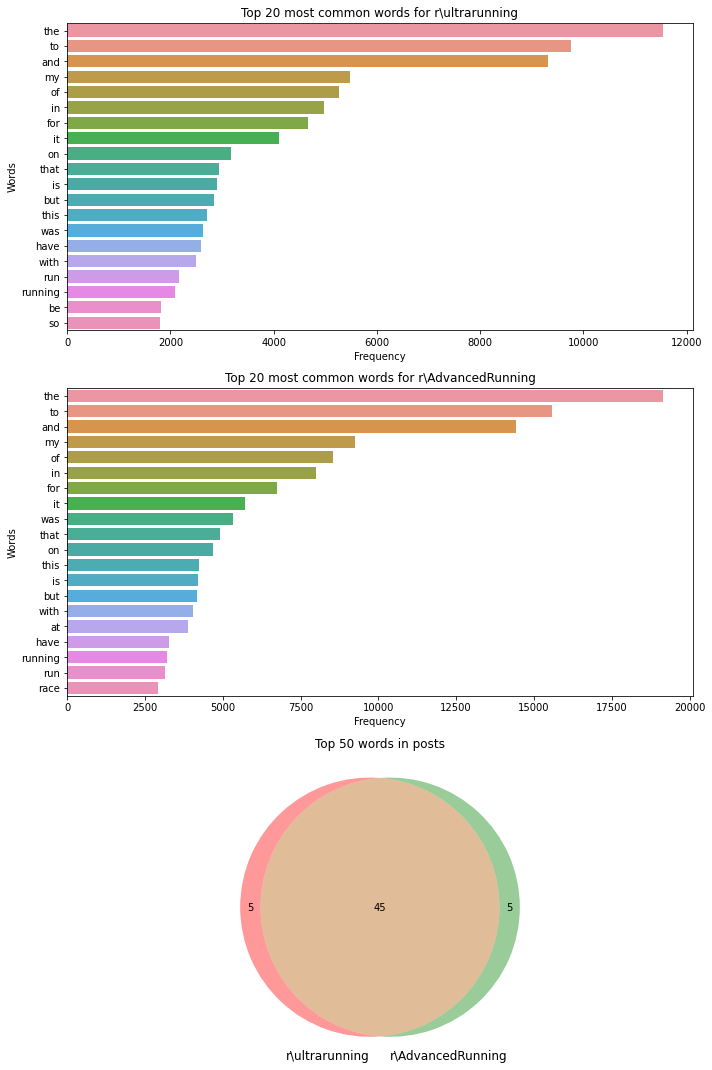

In [50]:
# Check most frequent words for subreddits
frequentwords(df, 'cleaned_2')

Both subreddits have quite similar common words! That doesn't bode well for differentiating between subreddits. I shall apply NLTK's default stop word dictionary and see if anything changes.

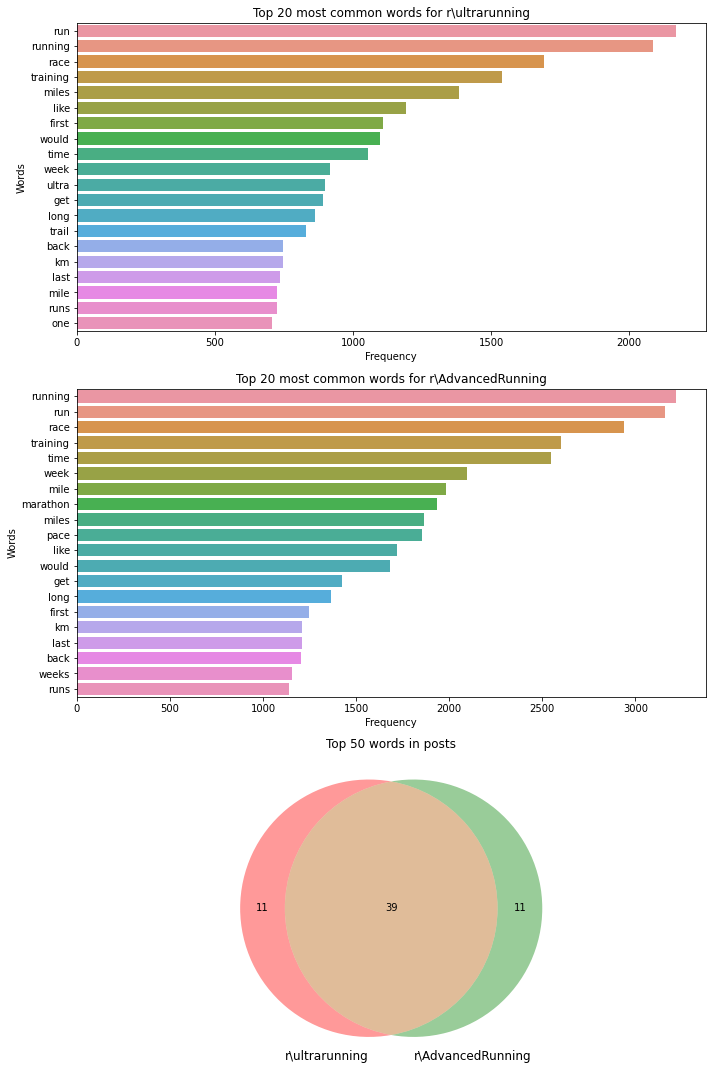

In [51]:
# Apply nltk stop words
words_to_remove = stopwords.words('english')

# Check most frequent words after stop word removal
frequentwords(df, 'cleaned_2', words_to_remove)

Looking better now. We have 38 overlapping words amongst the top 50 most common words in each subreddit community. Here are some additional words to remove in the next round:
- Remove "ultrarunning" and "advancedrunning" from both subreddits, to avoid giving the model an unfair advantage by including the name of the subreddit community. 
- Remove common running words such as "run", "running", "race", "training", "miles", "mile"

In [52]:
# Round 3: Expand stop word dictionary
words_to_remove += ["ultrarunning", "advancedrunning"]
words_to_remove += ["run", "running", "race", "training", "miles", "mile"]

In [53]:
# Check last few words in dict
words_to_remove[-20:]

['shan',
 "shan't",
 'shouldn',
 "shouldn't",
 'wasn',
 "wasn't",
 'weren',
 "weren't",
 'won',
 "won't",
 'wouldn',
 "wouldn't",
 'ultrarunning',
 'advancedrunning',
 'run',
 'running',
 'race',
 'training',
 'miles',
 'mile']

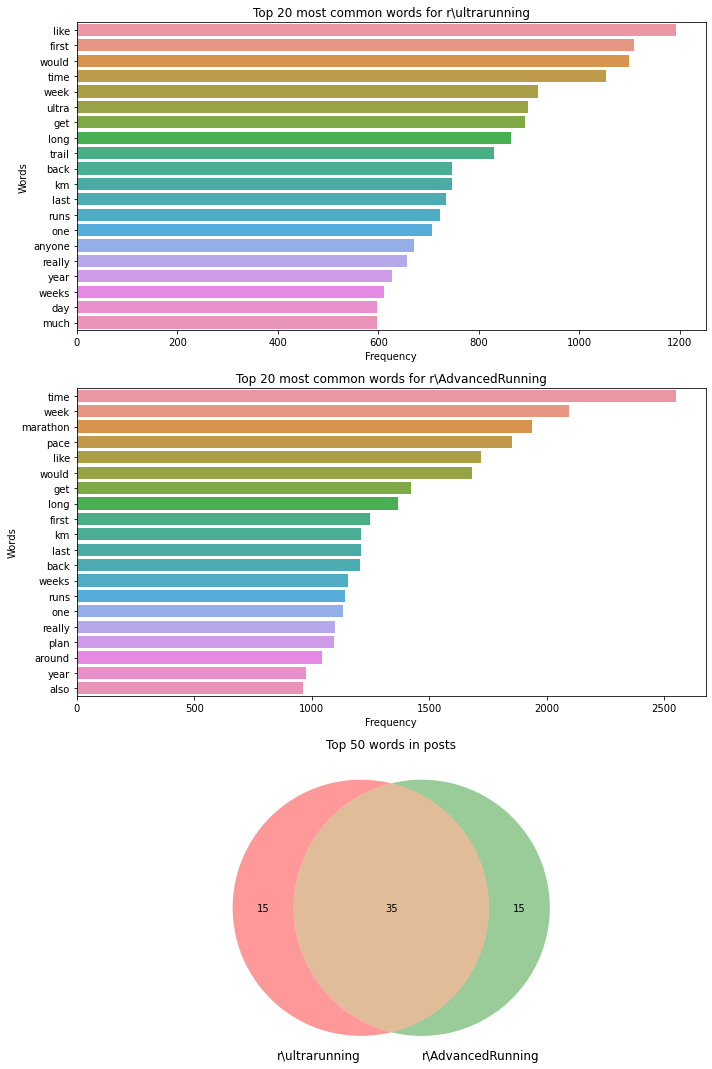

In [54]:
# Check most frequent words after additional stop words 
frequentwords(df, 'cleaned_2', words_to_remove)

The most frequently used words are starting to look a little more different between the two subreddits but still a lot of similarities. It seems like it may be an uphill task for my classification model later. 

However, we cannot just remove all intersected words as they may be constituents of meaningful bigrams or trigrams. Let's take a look at them now.


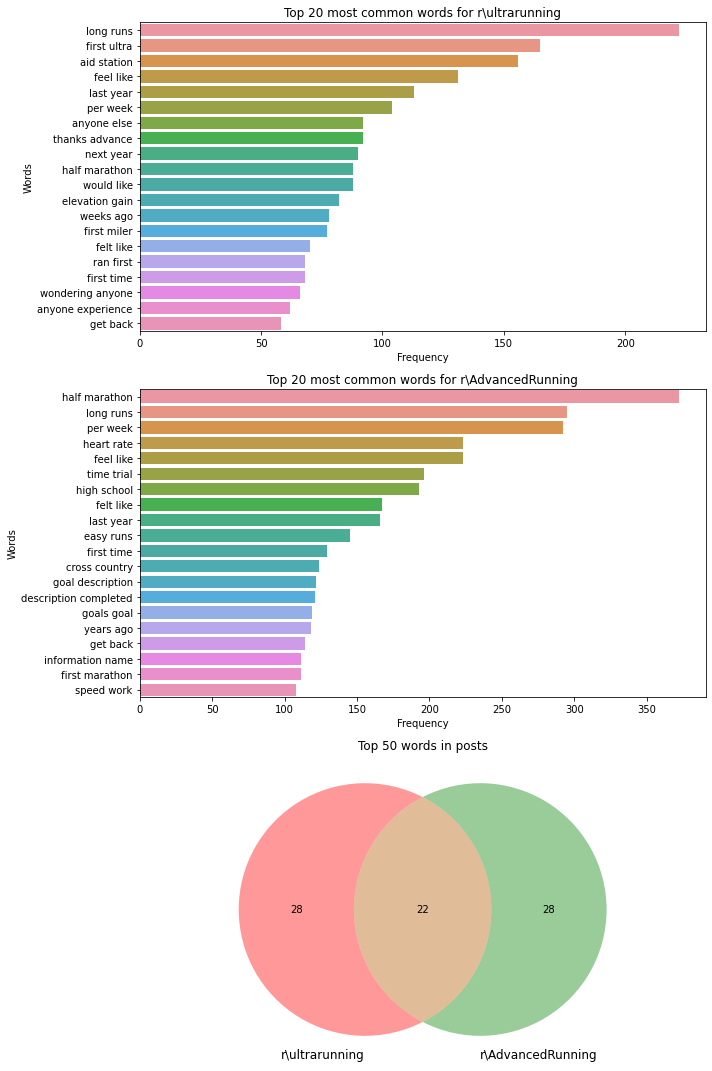

In [55]:
# Analyze bi-grams in subreddits
frequentwords(df, 'cleaned_2', words_to_remove, 2)

Bi-grams for both subreddits are also quite different. Only 22 bi-grams are found in both subreddits' top 50 common words.

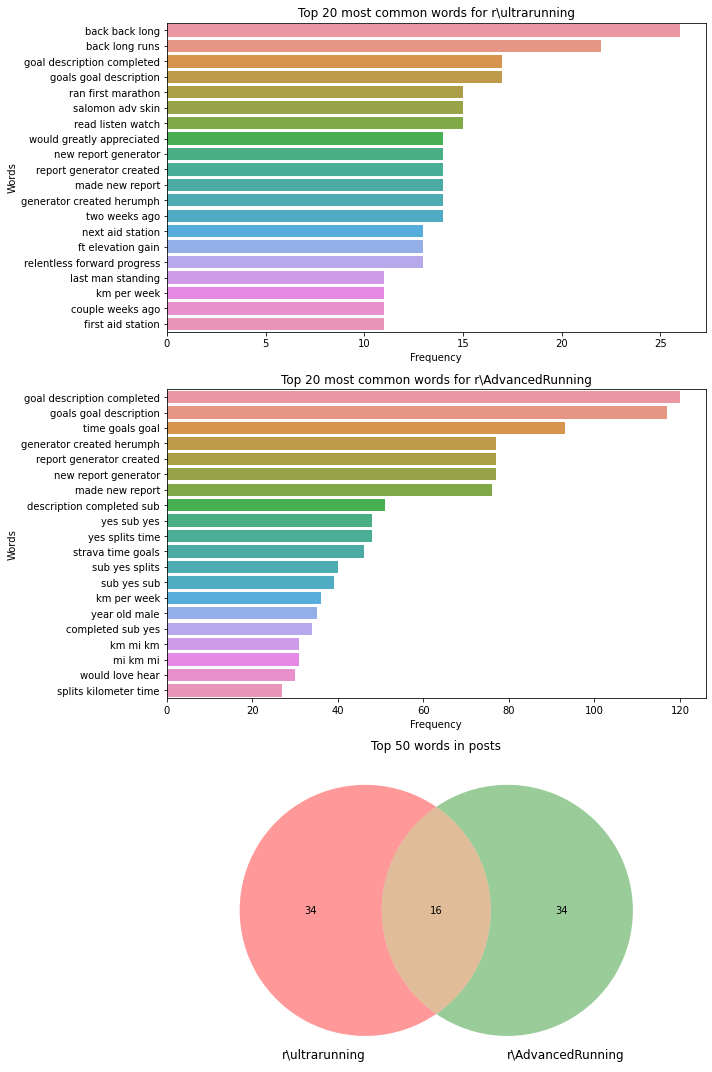

In [56]:
# Analyze tri-grams in subredditsa
frequentwords(df, 'cleaned_2', words_to_remove, 3)

I can see more differentiation in tri-grams coming from the two subreddit communities. That gives a bit of hope for the modeling, as I can run word vectorizers that utilize bigrams and trigrams.

### Lemmatize and stemmatize

Next step is to lemmatize the word tokens.

In [57]:
# Lemmatize after removing stop words
lemmatizer = WordNetLemmatizer()

df['cleaned_lemma'] = df['cleaned_3'].map(
    lambda x: [lemmatizer.lemmatize(token) \
               for token in x \
               if token not in words_to_remove]
).map(
    lambda x: ' '.join(x)
)

In [58]:
# Check
df[['cleaned_2', 'cleaned_lemma']].sample(5)

,cleaned_2,cleaned_lemma
2353,I m running my first ultra trail run this weekend Duncan Ridge K elevation gain Unfortunately the weather isn t cooperating It s expected to be degrees with steady rain all day Any gear attitude practice tips to minimize the wet weather s effect on my run would be appreciated There are aid stations every miles and I can leave a drop bag at the halfway point,first ultra trail weekend duncan ridge k elevation gain unfortunately weather cooperating expected degree steady rain day gear attitude practice tip minimize wet weather effect would appreciated aid station every leave drop bag halfway point
2526,Running a marathon in two weeks Need good recs for the best socks to race in I ve never worn compression socks while racing before so I m open to that Wondering what y all race in,marathon two week need good recs best sock never worn compression sock racing open wondering
2229,Hey everyone I m eyeing up challenges for next year ULTRALONDON of which I completed the km distance this year are organizing a km event in June km first day km next day I ve ran km twice fastest being My marathon PB is currently I d have felt much better each time had I managed electrolyte consumption better I m willing to put in the work to train for it but is it reasonable to go from km gt split km in months What weekly time distance would you personally want to achieve to feel comfortable I think back to back runs would be a good simulation but they take a hell of a lot out of the body and injury management is usually my toughest problem They leave entries open quite late so I don t need to sign up yet but should I be looking for an km race first,hey everyone eyeing challenge next year ultralondon completed km distance year organizing km event june km first day km next day ran km twice fastest marathon pb currently felt much better time managed electrolyte consumption better willing put work train reasonable go km gt split km month weekly time distance would personally want achieve feel comfortable think back back run would good simulation take hell lot body injury management usually toughest problem leave entry open quite late need sign yet looking km first
2344,I am a poor student which is why I can t really afford a lot of clothes at once by the big names in the scene like Salomon etc Though I kind of have to get some sets of earm clothes for the winter since I don t have any I have the opportunity to get my hands on a bunch of Under Armour long sleeves and tights for a fairly cheap price which leads to my question Have you made experiences with this brand in ultra distance running and if yes how were they,poor student really afford lot clothes big name scene like salomon etc though kind get set earm clothes winter since opportunity get hand bunch armour long sleeve tights fairly cheap price lead question made experience brand ultra distance yes
2515,I am now in the first week of a two week long taper phase for the race again with advice taken from Jack Daniels and this sub Two weeks after this half marathon race I have signed up for a K road race as all my workouts have suggested an incrementally improving K time and I d like to test it out Assuming I follow a JD formula of days easy running following the half marathon i e one week after race how do I best spend the final week pre K race g up from mpw during the Blue Plan and have hit my workouts well I am now in the first week of a two week long taper phase for the race again with advice taken from Jack Daniels and this sub Two weeks after this half marathon race I have signed up for a K road race as all my workouts have suggested an incrementally improving K time and I d like to test it out Assuming I follow a JD formula of days easy running following the half marathon i e one week after race how do I best spend the final week pre K race Do I loose too much fitness if that second week is also an easy taper,first week two week long taper phase advice taken jack daniel su

Next, I apply [Porter's stemmer](https://www.cs.toronto.edu/~frank/csc2501/Readings/R2_Porter/Porter-1980.pdf) to return the base form of words. It tends to be cruder than using lemmatization only, so I shall check out both methods to see which works better.

In [59]:
# Stemmatize after removing stop words
stemmer = PorterStemmer()

df['cleaned_stemmer'] = df['cleaned_3'].map(
    lambda x: [stemmer.stem(token) \
               for token in x \
               if token not in words_to_remove]
).map(
    lambda x: ' '.join(x)
)

In [60]:
# Check
df[['cleaned_3', 'cleaned_lemma', 'cleaned_stemmer']].sample(5)

cleaned_3  \
3825                                                           [m, cm, kg, i, ve, just, finished, my, two, months, of, base, building, averaging, steady, mpw, with, no, sessions, i, did, a, k, tt, last, week, in, at, max, effort, how, much, improvement, over, weeks, is, reasonable, to, expect, i, m, starting, proper, training, again, this, week, and, i, ll, be, aiming, for, two, sessions, per, week, with, one, interval, session, one, tempo, or, hill, session, and, one, long, run, with, the, rest, of, the, days, being, easy, i, ve, signed, up, for, the, sale, sizzler, k, series, which, is, four, ks, all, weeks, apart, from, each, other, the, first, ...]   
3623  [this, past, sunday, i, completed, my, second, full, marathon, it, was, the, culmination, of, over, two, years, of, training, numerous, heartbreaks, and, being, hell, bent, to, redeem, myself, after, an, initial, failed, attempt, to, some, this, might, seem, like, a, normal, race, recap, but, for, me, it, s, so, much, more, than, that, below, is, an, account, of, an, emotional, two, year, span, background, my, first, marathon, was, an, abject, disaster, i, came, in, undertrained, over, tapered, inadequately, fueled, and, began, way, too, fast, if, there, was, a, rookie, mistake, in, marathon, training, i, made, it, and, although, it, served, ...]   
1437                                                                    [i, started, running, in, feb, this, year, and, have, surpassed, all, my, expectations, and, ran, a, marathon, k, and, k, this, year, pretty, slow, minute, miles, in, october, i, m, am, planning, to, do, my, first, sub, hour, marathon, before, i, move, to, from, the, uk, to, china, wanting, get, into, trail, ultras, so, i, can, explore, the, country, i, m, just, wondering, when, does, the, soreness, end, i, have, sore, calves, of, the, time, and, im, hoping, i, can, get, some, tips, that, help, me, minimize, this, soreness, without, cutting, down, on, long, runs, as, i, love, them]   
301                                                             [so, i, m, a, bit, of, a, novice, when, it, comes, to, ultras, only, done, a, few, ks, i, ve, been, running, for, several, years, now, all, as, a, hobbyist, never, ran, in, school, or, anything, like, that, i, ve, never, been, coached, i, m, interested, in, zone, training, i, ve, never, really, done, it, all, my, training, has, been, by, perceived, effort, i, follow, the, general, advice, of, the, rule, try, to, keep, myself, st, conversational, pace, most, of, the, time, can, someone, do, an, eli, on, zone, training, or, suggest, any, good, resources, suggestions, on, a, good, heart, ...]   
2953                                                                                                                                                                                                                                                                                                                    [doc, just, said, i, have, mono, and, won, t, be, able, to, train, for, up, to, weeks, thing, is, i, am, sick, but, not, incredibly, sick, how, should, i, go, about, this, in, a, way, to, lose, as, little, fitness, as, possible, my, xc, time, trials, are, this, week, and, i, had, to, tell, my, coaches, and, that, really, f, ckin, bummed, me, out]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

Stemmer looks terrible...but hey, it might work better! Let's see in the next section.

### Total word count again

In [61]:
# Count total number of words in lemmatized posts and stemmatized posts
print(f"The original total word count is {df['word_count'].sum()}.")
print(f"Total word count after lemmatization / stemmatization is {np.sum([len(x.split()) for x in df['cleaned_lemma']])}.")
# print(f"Total word count after stemmatization is {np.sum([len(x.split()) for x in df['cleaned_stemmer']])}.")

The original total word count is 889620.
Total word count after lemmatization / stemmatization is 407845.


In [62]:
df.shape

(4931, 12)

In [63]:
407845 / 889620 -1

-0.5415514489332525

To summarize, after data pre-processing, a total of 70 rows are removed (<2% of original), and about 54% of the words in posts are remove.

### Remove other special characters??

## Modeling

### Binarize subreddit column

I set r\Ultramarathon as "1" and r\ultrarunning as "0".

In [64]:
# Binarize
df['target'] = df['subreddit'].map({subreddit1 : 1,
                                    subreddit2: 0})


# Reset column width 
pd.set_option('display.max_colwidth', 50)

# Check
df

,subreddit,author,title,selftext,created_utc,word_count,cleaned_1,cleaned_2,sentiment,cleaned_3,cleaned_lemma,cleaned_stemmer,target
0,ultrarunning,WitheredBallSack,Signed up for an ultra 6 weeks away - help!!,I am a casual runner but a buddy of mine pushe...,1632745618,200,I am a casual runner but a buddy of mine pushe...,I am a casual runner but a buddy of mine pushe...,0.9499,"[i, am, a, casual, runner, but, a, buddy, of, ...",casual runner buddy mine pushed signing ultra ...,casual runner buddi mine push sign ultra earli...,1
1,ultrarunning,ck425,Weight loss three weeks out from first Ultra?,"Hi All,\n\nApologies I wrote this and added a ...",1632732641,428,"Hi All,\n\nApologies I wrote this and added a ...",Hi All Apologies I wrote this and added a lo...,0.7013,"[hi, all, apologies, i, wrote, this, and, adde...",hi apology wrote added load context add questi...,hi apolog wrote ad load context add question t...,1
2,ultrarunning,EramSumEro,White long-sleeved shirts for sun protection?,Running javelina jundred at the end of October...,1632708998,33,Running javelina jundred at the end of October...,Running javelina jundred at the end of October...,0.6369,"[running, javelina, jundred, at, the, end, of,...",javelina jundred end october considering using...,javelina jundr end octob consid use white long...,1
3,ultrarunning,jparker74,Adv Skin 12 Chest Lacing,Has anyone tried lacing it across your chest m...,1632699223,38,Has anyone tried lacing it across your chest m...,Has anyone tried lacing it across your chest m...,0.2398,"[has, anyone, tried, lacing, it, across, your,...",anyone tried lacing across chest time came set...,anyon tri lace across chest time came set mine...,1
4,ultrarunning,WholeAwareness4,Running Distance After Major Injuries,"Hi Folks,\nI’m sure this question comes up fro...",1632688783,194,"Hi Folks,\nI’m sure this question comes up fro...",Hi Folks I m sure this question comes up from...,0.9430,"[hi, folks, i, m, sure, this, question, comes,...",hi folk sure question come time time hoping re...,hi folk sure question come time time hope rece...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4926,AdvancedRunning,CarlSag,Does the Maffetone Method really prescribe all...,I picked up Phil Maffetone’s book “The Big Boo...,1608083446,97,I picked up Phil Maffetone’s book “The Big Boo...,I picked up Phil Maffetone s book The Big Boo...,0.7650,"[i, picked, up, phil, maffetone, s, book, the,...",picked phil maffetone book big book endurance ...,pick phil maffeton book big book endur race co...,0
4927,AdvancedRunning,not_alemur,What worked for you to treat your plantar fasc...,This is a first for me and I’m having trouble ...,1608082082,96,This is a first for me and I’m having trouble ...,This is a first for me and I m having trouble ...,0.6209,"[this, is, a, first, for, me, and, i, m, havin...",first trouble treating denial awhile pain need...,first troubl treat denial awhil pain need reso...,0
4928,AdvancedRunning,zps77,Those who trained through pregnancy - tips &am...,"Hey all,\n\nThe wife is just over 7 weeks preg...",1608081836,213,"Hey all,\n\nThe wife is just over 7 weeks preg...",Hey all The wife is just over weeks pregna...,0.9870,"[hey, all, the, wife, is, just, over, weeks, p...",hey wife week pregnant first one thing trying ...,hey wife week pregnant first one thing tri pla...,0
4929,AdvancedRunning,stillslammed,Questions about collegiate running as a grad s...,I'm almost done my undergrad and I'm looking a...,1608074462,133,I'm almost done my undergrad and I'm looking a...,I m almost done my undergrad and I m looking a...,0.9459,"[i, m, almost, done, my, undergrad, and, i, m,...",almost done undergrad looking different option...,almost done undergrad look differ option grad ...,0


### Baseline score

In [65]:
# Check baseline score
df.target.value_counts(normalize = True)

1    0.502941
0    0.497059
Name: target, dtype: float64

The baseline score to beat is 50.3%

### Check data again

In [66]:
# Check nulls
df.isnull().sum()

subreddit          0
author             0
title              0
selftext           0
created_utc        0
word_count         0
cleaned_1          0
cleaned_2          0
sentiment          0
cleaned_3          0
cleaned_lemma      0
cleaned_stemmer    0
target             0
dtype: int64

### Create train test sets

In [67]:
# Create train test sets
X = df['cleaned_lemma']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify = y,
    random_state = 42
)

In [68]:
# Check
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3698,), (1233,), (3698,), (1233,))

### Create performance tracking table

Here, I create a table to track the performance of various models as I attempt to find better models or feature engineering to improve my performance. Accuracy will be my main metric for performance measurement, and if it is a close fight, I shall use other secondary metrics such as sensitivity, specificity and precision to pick the best model. Here is a recap of their meanings:
- Sensitivity: true positive rate (correct positive predictions divided by total positives)
- Specificity: true negative rate (correct negative predictions divided by total negatives)
- Precision: positive predictive value (correct positive predictions divided by all positive predictions)

In [69]:
# Create empty results dataframe
df_results = pd.DataFrame(
    columns = [
        'Model No.',
        'Word Vectorizer',
        'Classifier',
        'CV Score (train)',
        'Accuracy (train)',
        'Accuracy (test)',
        'Sensitivity (test)',
        'Specificity (test)',
        'Precision (test)',
        'Runtime (sec)',
#         'Best Parameters',
        'Remarks'
    ]
)

In [70]:
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Runtime (sec),Remarks


### Create custom function

I create a custom function that automates a few steps:
* Instantiate a GridSearchCV
* Fit on train set
* Create confusion matrix on test set
* Print results of best parameters, best score, train score, test score and various confusion matrix metrics

In [71]:
# Create function to run pipe and print results
def run_grid(X_train, X_test, y_train, y_test):
    
    # Start 'stopwatch' to measure runtime
    tic = time.time()
    
    # Instantiate GridSearchCV
    gs = GridSearchCV(
        pipe, 
        param_grid = params, 
        n_jobs = -1, 
        cv = 5,
        verbose = 1
    )

    # Fit model
    gs.fit(X_train, y_train)

    # Confusion matrix
    y_pred = gs.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # End 'stopwatch' 
    toc = time.time()
    time_taken = toc - tic 
    
    # Find current length of df_results
    length = len(df_results)
    
    # Store results in new_row
    new_row = [{
        'Model No.' : length + 1,
        'Word Vectorizer' : pipe.steps[0][1],
        'Classifier' : pipe.steps[1][1],
        'CV Score (train)' : round(gs.best_score_, 3),
        'Accuracy (train)': round(gs.score(X_train, y_train), 3),
        'Accuracy (test)' : round(gs.score(X_test, y_test) ,3 ),
        'Sensitivity (test)' : round (tp/(tp+fn), 3),
        'Specificity (test)' : round (tn/(tn+fp), 3),
        'Precision (test)' : round (tp/(tp+fp), 3),
        'Runtime (sec)' : round(time_taken),
#         'Best Parameters' : gs.best_params_
    }]
    
    # Print best parameters from GridSearchCV
    print('Best Parameters:', gs.best_params_)
    
    return new_row

In [72]:
# # Create function to run pipe and print results
# def run_grid(X_train, X_test, y_train, y_test):
    
#     # Start 'stopwatch' to measure runtime
#     tic = time.time()
    
#     # Instantiate GridSearchCV
#     gs = GridSearchCV(
#         pipe, 
#         param_grid = params, 
#         n_jobs= -1, 
#         cv=5)

#     # Fit model
#     gs.fit(X_train, y_train)

#     # Confusion matrix
#     y_pred = gs.predict(X_test)
#     tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
#     # Store results in df_results

    
#     # Print results
#     print(f'Mean CV score: {gs.best_score_:.3f}')
#     print('Best Parameters:', gs.best_params_)
#     print(f'Train score: {gs.score(X_train, y_train):.3f}')
#     print(f'Test score (aka Accuracy): {gs.score(X_test, y_test):.3f}')
#     print(f'Sensitivity: {tp/(tp+fn):.3f}, Specificity: {tn/(tn+fp):.3f}, Precision: {tp/(tp+fp):.3f}')
    
    
    
#     #End 'stopwatch' 
#     toc = time.time()
#     time_taken = toc - tic 

### Parametric models

#### CountVectorizer / Multinomial

In [73]:
# Make pipe
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

# Set parameters
params = {
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.1, .5, 1],
    'cvec__max_features' : [1000, 2000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha': [.25, .5, 1]
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'cvec__max_df': 0.5, 'cvec__max_features': 2000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'nb__alpha': 0.5}


,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Runtime (sec),Remarks
0,1,CountVectorizer(),MultinomialNB(),0.796,0.83,0.783,0.856,0.71,0.749,86,NaN


The train score (0.830) is not too much higher than test score (0.783), so this model is not too overfitted. The average 5-fold cross-validation score on the train set is lower at 0.796, which is to be expected.

As there are too many common words across all posts and between subreddits ([common_words_analysis](#common_words)), I shall try Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer next. This method will give more weight to words that occur often in one post but don't occur in many posts, hopefully this can create more predictive power in my model.

#### TfidfVectorizer / Multinomial

In [74]:
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [.1, .5, 1],
    'tvec__max_features' : [1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha': [.25, .5, 1]
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'nb__alpha': 0.5, 'tvec__max_df': 0.5, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}


,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Runtime (sec),Remarks
0,1,CountVectorizer(),MultinomialNB(),0.796,0.830,0.783,0.856,0.710,0.749,86,NaN
0,2,TfidfVectorizer(),MultinomialNB(),0.810,0.853,0.788,0.818,0.759,0.774,87,NaN


As expected, TF-IDF vectorizer work better. The mean cross-validated score, train score and test score are higher than Count vectorizer's. 
Will try logit model next.

#### CountVectorizer / Logistic

In [75]:
# Make pipe
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logit', LogisticRegression())
])

# Set parameters
params = {
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.1, .5, 1],
    'cvec__max_features' : [1000, 2000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'logit__C': [0.1, 1, 10],
    'logit__max_iter': [1_000]
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'cvec__max_df': 0.5, 'cvec__max_features': 2000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'logit__C': 0.1, 'logit__max_iter': 1000}


,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Runtime (sec),Remarks
0,1,CountVectorizer(),MultinomialNB(),0.796,0.830,0.783,0.856,0.710,0.749,86,NaN
0,2,TfidfVectorizer(),MultinomialNB(),0.810,0.853,0.788,0.818,0.759,0.774,87,NaN
0,3,CountVectorizer(),LogisticRegression(),0.806,0.920,0.796,0.818,0.773,0.785,94,NaN


Logistic model suffers from a more severe case of overfitting as its train score is much higher than test (0.920 vs 0.796). Let's try out TD-IDF vectorizer on logit model next...

#### TfidfVectorizer / Logistic

In [76]:
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logit', LogisticRegression())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [.1, .5, 1],
    'tvec__max_features' : [1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'logit__C': [0.1, 1, 10],
    'logit__max_iter': [1_000]
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'logit__C': 1, 'logit__max_iter': 1000, 'tvec__max_df': 0.5, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}


,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Runtime (sec),Remarks
0,1,CountVectorizer(),MultinomialNB(),0.796,0.830,0.783,0.856,0.710,0.749,86,NaN
0,2,TfidfVectorizer(),MultinomialNB(),0.810,0.853,0.788,0.818,0.759,0.774,87,NaN
0,3,CountVectorizer(),LogisticRegression(),0.806,0.920,0.796,0.818,0.773,0.785,94,NaN
0,4,TfidfVectorizer(),LogisticRegression(),0.824,0.899,0.801,0.818,0.785,0.793,87,NaN


Logit model with TF-IDF vectorizer is the winner so far. All scores (mean CV, train, test) beat the first 3 models.

### Non-parametric models

I shall now ask non-parametric models to come to the rescue, as they have been performing well in Kaggle contests. Will try out Random Forests and Extra Trees next. 

#### CountVectorizer / RandomForest

In [77]:
# Make pipe
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

# Set parameters
params = {
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.1, .5, 1],
    'cvec__max_features' : [1000, 2000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth' : [5, 10, None]
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'cvec__max_df': 0.5, 'cvec__max_features': 2000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'rf__max_depth': None, 'rf__n_estimators': 200}


,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Runtime (sec),Remarks
0,1,CountVectorizer(),MultinomialNB(),0.796,0.830,0.783,0.856,0.710,0.749,86,NaN
0,2,TfidfVectorizer(),MultinomialNB(),0.810,0.853,0.788,0.818,0.759,0.774,87,NaN
0,3,CountVectorizer(),LogisticRegression(),0.806,0.920,0.796,0.818,0.773,0.785,94,NaN
0,4,TfidfVectorizer(),LogisticRegression(),0.824,0.899,0.801,0.818,0.785,0.793,87,NaN
0,5,CountVectorizer(),RandomForestClassifier(),0.812,0.999,0.805,0.797,0.814,0.812,530,NaN


RandomForest comes quite close to my prefered parametrics model (Model 4: Tdidf-Logit) in terms of CV score and test score. However, I see that it suffers from a severe case of overfitting, as its train score is near-perfect while its test score is 20% lower. Let's see if RandomForest works better if the words are vectorized using TF-IDF.

#### TfidfVectorizer / RandomForest

In [78]:
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [.1, .5, 1],
    'tvec__max_features' : [1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth' : [5, 10, None]
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'rf__max_depth': None, 'rf__n_estimators': 300, 'tvec__max_df': 0.5, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}


,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Runtime (sec),Remarks
0,1,CountVectorizer(),MultinomialNB(),0.796,0.830,0.783,0.856,0.710,0.749,86,NaN
0,2,TfidfVectorizer(),MultinomialNB(),0.810,0.853,0.788,0.818,0.759,0.774,87,NaN
0,3,CountVectorizer(),LogisticRegression(),0.806,0.920,0.796,0.818,0.773,0.785,94,NaN
0,4,TfidfVectorizer(),LogisticRegression(),0.824,0.899,0.801,0.818,0.785,0.793,87,NaN
0,5,CountVectorizer(),RandomForestClassifier(),0.812,0.999,0.805,0.797,0.814,0.812,530,NaN
0,6,TfidfVectorizer(),RandomForestClassifier(),0.815,0.999,0.785,0.802,0.768,0.778,542,NaN


Using TF-IDF seems to make it slightly worse, underperforming its Count Vectorizer cousin (Model 5) on the test score. It also seems to suffer from same level of overfitting as Model 5, as the difference between its train-test accuracy score is 20%.

#### CountVectorizer / ExtraTrees

In [79]:
# Make pipe
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('et', ExtraTreesClassifier())
])

# Set parameters
params = {
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.1, .5, 1],
    'cvec__max_features' : [1000, 2000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'et__n_estimators': [100, 200, 300],
    'et__max_depth' : [5, 10, None]
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'cvec__max_df': 0.5, 'cvec__max_features': 2000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'et__max_depth': None, 'et__n_estimators': 300}


,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Runtime (sec),Remarks
0,1,CountVectorizer(),MultinomialNB(),0.796,0.830,0.783,0.856,0.710,0.749,86,NaN
0,2,TfidfVectorizer(),MultinomialNB(),0.810,0.853,0.788,0.818,0.759,0.774,87,NaN
0,3,CountVectorizer(),LogisticRegression(),0.806,0.920,0.796,0.818,0.773,0.785,94,NaN
0,4,TfidfVectorizer(),LogisticRegression(),0.824,0.899,0.801,0.818,0.785,0.793,87,NaN
0,5,CountVectorizer(),RandomForestClassifier(),0.812,0.999,0.805,0.797,0.814,0.812,530,NaN
0,6,TfidfVectorizer(),RandomForestClassifier(),0.815,0.999,0.785,0.802,0.768,0.778,542,NaN
0,7,CountVectorizer(),ExtraTreesClassifier(),0.815,0.999,0.783,0.756,0.811,0.802,508,NaN


ExtraTrees is not too different from its RandomForest cousin (Model 5), as its mean CV score, train score and test score are virtually the same when rounded to 2 decimal places. Not sure if TF-IDF will make it much better, let's try it next.

#### TfidfVectorizer / ExtraTrees

In [80]:
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('et', ExtraTreesClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [.1, .5, 1],
    'tvec__max_features' : [1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'et__n_estimators': [100, 200, 300],
    'et__max_depth' : [5, 10, None]
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'et__max_depth': None, 'et__n_estimators': 300, 'tvec__max_df': 0.5, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}


,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Runtime (sec),Remarks
0,1,CountVectorizer(),MultinomialNB(),0.796,0.830,0.783,0.856,0.710,0.749,86,NaN
0,2,TfidfVectorizer(),MultinomialNB(),0.810,0.853,0.788,0.818,0.759,0.774,87,NaN
0,3,CountVectorizer(),LogisticRegression(),0.806,0.920,0.796,0.818,0.773,0.785,94,NaN
0,4,TfidfVectorizer(),LogisticRegression(),0.824,0.899,0.801,0.818,0.785,0.793,87,NaN
0,5,CountVectorizer(),RandomForestClassifier(),0.812,0.999,0.805,0.797,0.814,0.812,530,NaN
0,6,TfidfVectorizer(),RandomForestClassifier(),0.815,0.999,0.785,0.802,0.768,0.778,542,NaN
0,7,CountVectorizer(),ExtraTreesClassifier(),0.815,0.999,0.783,0.756,0.811,0.802,508,NaN
0,8,TfidfVectorizer(),ExtraTreesClassifier(),0.819,0.999,0.794,0.781,0.808,0.804,516,NaN


In contrast to RandomForest's experience, using TF-IDF slightly improved the performance of ExtraTrees, as scores increased throughout. Let me now do a review of all 8 model permutations thus far:
- Within the parametric space, I would prefer Model 4 over Models 1-3. It has the highest average CV score (done on 5 folds of train set) and it is borne out by a high test score too. 
- Within the non-parametric space, the clear winner is Model 8, as it has the highest CV score and test score.

To continue with my selection process, I shall pick Models 4 and 8 for subsequent analyses.

In [81]:
# Populate 'Remarks' column
df_results['Remarks'][:8] = 'Lemmatized'

### Stemmatized words

So far, we have dealt with lemmatized words. Next, I shall apply [Porter's stemmer](https://www.cs.toronto.edu/~frank/csc2501/Readings/R2_Porter/Porter-1980.pdf) to return the base form of words. It tends to be cruder than using lemmatization only, but it could potentially generate better model performance.

In [82]:
# Create train test sets on stemmatized words
X_stem = df['cleaned_stemmer']
y_stem = df['subreddit']

X_stem_train, X_stem_test, y_stem_train, y_stem_test = train_test_split(
    X_stem, y_stem,
    stratify = y_stem,
    random_state = 42
)

In [83]:
# Check
X_stem_train.shape, X_stem_test.shape, y_stem_train.shape, y_stem_test.shape

((3698,), (1233,), (3698,), (1233,))

To save on runtime, I shall run stemmatized words on our leading contenders for parametric and non-parametric models: Model 4 and Model 8 only. To further save on the grid search time, I shall cut down on the number of features using the knowledge gained from Models 1-8:
- min_df (consider words that occur in at least X number of documents.): Some models consistently chose X=2 while other picked X=1 as the optimal selection, so I shall keep both parameter choices. 
- max_df (consider words that occur in at most X% of documents.): All models consistently chose X=0.5 as the optimal selection, so I shall drop \[0.1, 0.25, 1.0\] as  parameter choices.
- max_features (only include the X most popular vocabulary words): All models picked either 1000 or 2000 as optimal choice, so I will keep both.
- ngram_range: All 3 options \[(1,1), (1,2), (1,3)\] are used by both cvec and tvec, so I shall leave these ranges unchanged.
- n_estimators (number of trees to plant): All models picked 100 or 200, I shall drop 300 as an option.
- max_depth: All models did not want to be constrained by depth, so I will retain None as the only option, dropping 5 and 10.

#### TfidfVectorizer / Logistic

In [84]:
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logit', LogisticRegression())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'logit__C': [0.1, 1, 10],
    'logit__max_iter': [1_000]
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_stem_train, X_stem_test, y_stem_train, y_stem_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'logit__C': 1, 'logit__max_iter': 1000, 'tvec__max_df': 0.5, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}


In [85]:
# Populate 'Remarks' column
df_results.loc[df_results['Model No.'] == 9, 'Remarks'] = 'Stemmatized, cousin of Model 4'
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Runtime (sec),Remarks
0,1,CountVectorizer(),MultinomialNB(),0.796,0.830,0.783,0.856,0.710,0.749,86,Lemmatized
0,2,TfidfVectorizer(),MultinomialNB(),0.810,0.853,0.788,0.818,0.759,0.774,87,Lemmatized
0,3,CountVectorizer(),LogisticRegression(),0.806,0.920,0.796,0.818,0.773,0.785,94,Lemmatized
0,4,TfidfVectorizer(),LogisticRegression(),0.824,0.899,0.801,0.818,0.785,0.793,87,Lemmatized
0,5,CountVectorizer(),RandomForestClassifier(),0.812,0.999,0.805,0.797,0.814,0.812,530,Lemmatized
0,6,TfidfVectorizer(),RandomForestClassifier(),0.815,0.999,0.785,0.802,0.768,0.778,542,Lemmatized
0,7,CountVectorizer(),ExtraTreesClassifier(),0.815,0.999,0.783,0.756,0.811,0.802,508,Lemmatized
0,8,TfidfVectorizer(),ExtraTreesClassifier(),0.819,0.999,0.794,0.781,0.808,0.804,516,Lemmatized
0,9,TfidfVectorizer(),LogisticRegression(),0.823,0.903,0.810,0.816,0.804,0.808,32,"Stemmatized, cousin of Model 4"


It is not clear if stemmatized words are better thant lemmatized, as Model 9's test score is higher (which may be a fluke) but its 5-fold CV score is lower. Let's see if we get a better read of stemming's capability with ExtraTrees.

#### TfidfVectorizer / ExtraTrees

In [86]:
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('et', ExtraTreesClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'et__n_estimators': [100, 200],
    'et__max_depth' : [None]
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_stem_train, X_stem_test, y_stem_train, y_stem_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'et__max_depth': None, 'et__n_estimators': 200, 'tvec__max_df': 0.5, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}


In [87]:
# Populate 'Remarks' column
df_results.loc[df_results['Model No.'] == 10, 'Remarks'] = 'Stemmatized, cousin of Model 8'
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Runtime (sec),Remarks
0,1,CountVectorizer(),MultinomialNB(),0.796,0.830,0.783,0.856,0.710,0.749,86,Lemmatized
0,2,TfidfVectorizer(),MultinomialNB(),0.810,0.853,0.788,0.818,0.759,0.774,87,Lemmatized
0,3,CountVectorizer(),LogisticRegression(),0.806,0.920,0.796,0.818,0.773,0.785,94,Lemmatized
0,4,TfidfVectorizer(),LogisticRegression(),0.824,0.899,0.801,0.818,0.785,0.793,87,Lemmatized
0,5,CountVectorizer(),RandomForestClassifier(),0.812,0.999,0.805,0.797,0.814,0.812,530,Lemmatized
0,6,TfidfVectorizer(),RandomForestClassifier(),0.815,0.999,0.785,0.802,0.768,0.778,542,Lemmatized
0,7,CountVectorizer(),ExtraTreesClassifier(),0.815,0.999,0.783,0.756,0.811,0.802,508,Lemmatized
0,8,TfidfVectorizer(),ExtraTreesClassifier(),0.819,0.999,0.794,0.781,0.808,0.804,516,Lemmatized
0,9,TfidfVectorizer(),LogisticRegression(),0.823,0.903,0.810,0.816,0.804,0.808,32,"Stemmatized, cousin of Model 4"
0,10,TfidfVectorizer(),ExtraTreesClassifier(),0.822,0.999,0.793,0.777,0.809,0.805,77,"Stemmatized, cousin of Model 8"


The flipside is true for ExtraTrees. Its test score dropped but CV score increased, when compared to its lemmatized cousin Model 8.

My conclusion is that stemmatized words does not bring about a discernible performance over lemmatized words. 
- On test scores, Model 9 performs better than its lemmatized cousin Model 4, but Model 10 performs worse than its lemmatized cousin Model 8.
- On CV scores, Model 10 performs better than its lemmatized cousin Model 8, but Model 9 performas worse than its lemmatized cousin Model 4.
- On an absolute scale, none of the score differences exceed more than 1%, so they are quite immaterial.

Given the inconclusiveness, I shall stick to lemmatization  for now. Let me try to find other ways to improve model performance...

<a id='without_1-gram'></a>
### Try without 1-gram

As shown in my venn diagrams in section 5.11 ([common words analysis](#common_words)), 1-grams have a lot of intersection of words compared to bi-grams and tri-grams. Perhaps I can improve model performance by setting ngram-range to avoid 1-grams, i.e. set range of \[(2,2), (2,3)\]. 

#### TfidfVectorizer / Logistic

In [88]:
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logit', LogisticRegression())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [1000, 2000],
    'tvec__ngram_range': [(2,2), (2,3)],
    'logit__C': [0.1, 1, 10],
    'logit__max_iter': [1_000]
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'logit__C': 1, 'logit__max_iter': 1000, 'tvec__max_df': 0.5, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (2, 2)}


In [89]:
# Populate 'Remarks' column
df_results.loc[df_results['Model No.'] == 11, 'Remarks'] = 'Lemmatized, only bi-grams and tri-grams'
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Runtime (sec),Remarks
0,1,CountVectorizer(),MultinomialNB(),0.796,0.830,0.783,0.856,0.710,0.749,86,Lemmatized
0,2,TfidfVectorizer(),MultinomialNB(),0.810,0.853,0.788,0.818,0.759,0.774,87,Lemmatized
0,3,CountVectorizer(),LogisticRegression(),0.806,0.920,0.796,0.818,0.773,0.785,94,Lemmatized
0,4,TfidfVectorizer(),LogisticRegression(),0.824,0.899,0.801,0.818,0.785,0.793,87,Lemmatized
0,5,CountVectorizer(),RandomForestClassifier(),0.812,0.999,0.805,0.797,0.814,0.812,530,Lemmatized
0,6,TfidfVectorizer(),RandomForestClassifier(),0.815,0.999,0.785,0.802,0.768,0.778,542,Lemmatized
0,7,CountVectorizer(),ExtraTreesClassifier(),0.815,0.999,0.783,0.756,0.811,0.802,508,Lemmatized
0,8,TfidfVectorizer(),ExtraTreesClassifier(),0.819,0.999,0.794,0.781,0.808,0.804,516,Lemmatized
0,9,TfidfVectorizer(),LogisticRegression(),0.823,0.903,0.810,0.816,0.804,0.808,32,"Stemmatized, cousin of Model 4"
0,10,TfidfVectorizer(),ExtraTreesClassifier(),0.822,0.999,0.793,0.777,0.809,0.805,77,"Stemmatized, cousin of Model 8"


Performance degradation is significant, so it looks like it is better to keep 1-grams even though there are many overlapping common words between both subreddits.

#### TfidfVectorizer / ExtraTrees

In [90]:
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('et', ExtraTreesClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [1000, 2000],
    'tvec__ngram_range': [(2,2), (2,3)],
    'et__n_estimators': [100, 200],
    'et__max_depth' : [None]
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'et__max_depth': None, 'et__n_estimators': 100, 'tvec__max_df': 0.5, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (2, 2)}


In [91]:
# Populate 'Remarks' column
df_results.loc[df_results['Model No.'] == 12, 'Remarks'] = 'Lemmatized, only bi-grams and tri-grams'
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Runtime (sec),Remarks
0,1,CountVectorizer(),MultinomialNB(),0.796,0.830,0.783,0.856,0.710,0.749,86,Lemmatized
0,2,TfidfVectorizer(),MultinomialNB(),0.810,0.853,0.788,0.818,0.759,0.774,87,Lemmatized
0,3,CountVectorizer(),LogisticRegression(),0.806,0.920,0.796,0.818,0.773,0.785,94,Lemmatized
0,4,TfidfVectorizer(),LogisticRegression(),0.824,0.899,0.801,0.818,0.785,0.793,87,Lemmatized
0,5,CountVectorizer(),RandomForestClassifier(),0.812,0.999,0.805,0.797,0.814,0.812,530,Lemmatized
0,6,TfidfVectorizer(),RandomForestClassifier(),0.815,0.999,0.785,0.802,0.768,0.778,542,Lemmatized
0,7,CountVectorizer(),ExtraTreesClassifier(),0.815,0.999,0.783,0.756,0.811,0.802,508,Lemmatized
0,8,TfidfVectorizer(),ExtraTreesClassifier(),0.819,0.999,0.794,0.781,0.808,0.804,516,Lemmatized
0,9,TfidfVectorizer(),LogisticRegression(),0.823,0.903,0.810,0.816,0.804,0.808,32,"Stemmatized, cousin of Model 4"
0,10,TfidfVectorizer(),ExtraTreesClassifier(),0.822,0.999,0.793,0.777,0.809,0.805,77,"Stemmatized, cousin of Model 8"


Also can't work...performance degradation is worse with ExtraTrees, so it looks like it is better to keep 1-grams even though there are many overlapping common words between both subreddits.
Now, let's try another feature engineering method: extreme removal of intersection word

### Extreme removal of intersection words!

In section 5.11 ([common words analysis](#common_words)), a lot of common words that overlap in the two subreddit communities. Originally, I did not want to remove too many of them for fear that they may be useful constituents of bi-grams or tri-grams: only 9 words were removed \["ultramarathon", "ultramarathons", "ultrarunning", "run", "running", "race", "training", "miles", "mile"\]. 
However, my analysis in Section 6.9 above shows that bi-grams and tri-grams do not contribute significantly to predictive prowess, so I shall now go agressive in removing common single words.

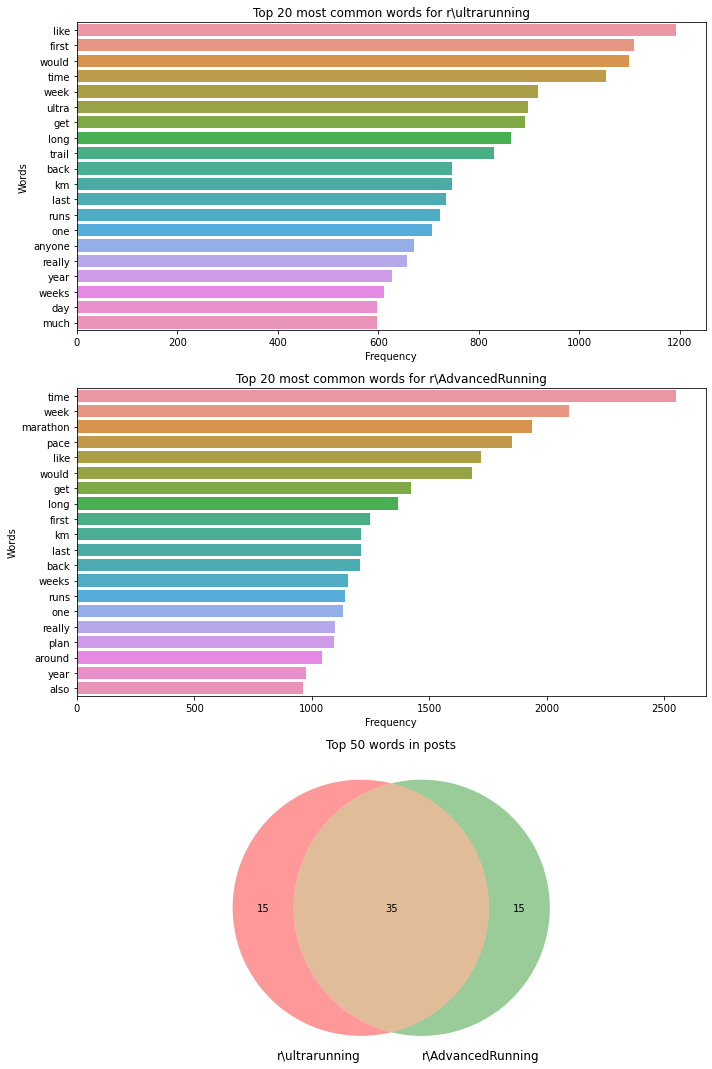

In [92]:
# Recap of common words between subreddits
frequentwords(df, 'cleaned_2', words_to_remove)

Out of the 50 most common words in the two subreddit communities, 35 intersect. Initially, I did not want to remove them as they may be constituents of useful bi-grams and tri-grams. But look at my results in Section 6.10 ([try_without_1-gram](#without_1-gram)), bi-grams and tri-grams do not seem to be as useful as I thought. Let's go aggressive and remove all these intersecting single words to see if it could lead to better predictive models.

#### Create custom function

In [93]:
def intersect_words(data, column_name, number_of_words = 50):
    cvec = CountVectorizer()
    
    # Create word vector on subreddit1 
    vector1 = cvec.fit_transform(
        data.loc[
            data['subreddit'] == subreddit1,
            column_name
        ]
    )
    vector1_df = pd.DataFrame(
        vector1.todense(),
        columns = cvec.get_feature_names()
    ).sum(
    ).sort_values(
        ascending = False
    ).head(number_of_words)

    # Create word vector on subreddit2
    vector2 = cvec.fit_transform(
        data.loc[
            data['subreddit'] == subreddit2,
            column_name
        ]
    )
    vector2_df = pd.DataFrame(
        vector2.todense(),
        columns = cvec.get_feature_names()
    ).sum(
    ).sort_values(
        ascending = False
    ).head(number_of_words)
    

    # Merge both dfs to get a df of intersection words
    unique_words = pd.merge(
        pd.DataFrame(vector1_df),
        pd.DataFrame(vector2_df),
        how='inner', 
        left_on = pd.DataFrame(vector1_df).index, 
        right_on = pd.DataFrame(vector2_df).index)

    return list(unique_words['key_0'].ravel())

#### Obtain intersection of 50 most common words

In [94]:
# Find intersecting words
intersect = intersect_words(df, 'cleaned_lemma', 50)

In [95]:
# Check length to make sure function works
len(intersect)

35

In [96]:
# Review intersecting words
intersect

['week',
 'time',
 'like',
 'first',
 'would',
 'year',
 'day',
 'get',
 'long',
 'back',
 'km',
 'one',
 'last',
 'run',
 'really',
 'marathon',
 'plan',
 'much',
 'know',
 'good',
 'feel',
 'also',
 'runner',
 'going',
 'month',
 'ran',
 'got',
 'go',
 'distance',
 'around',
 'could',
 'think',
 'two',
 'started',
 'still']

#### Remove intersection words

In [97]:
# Round 3: Expand stop word dictionary
words_to_remove_new = words_to_remove + intersect

In [98]:
# Check newly added words to stop-word dictionary
words_to_remove_new[-50:]

["wasn't",
 'weren',
 "weren't",
 'won',
 "won't",
 'wouldn',
 "wouldn't",
 'ultrarunning',
 'advancedrunning',
 'run',
 'running',
 'race',
 'training',
 'miles',
 'mile',
 'week',
 'time',
 'like',
 'first',
 'would',
 'year',
 'day',
 'get',
 'long',
 'back',
 'km',
 'one',
 'last',
 'run',
 'really',
 'marathon',
 'plan',
 'much',
 'know',
 'good',
 'feel',
 'also',
 'runner',
 'going',
 'month',
 'ran',
 'got',
 'go',
 'distance',
 'around',
 'could',
 'think',
 'two',
 'started',
 'still']

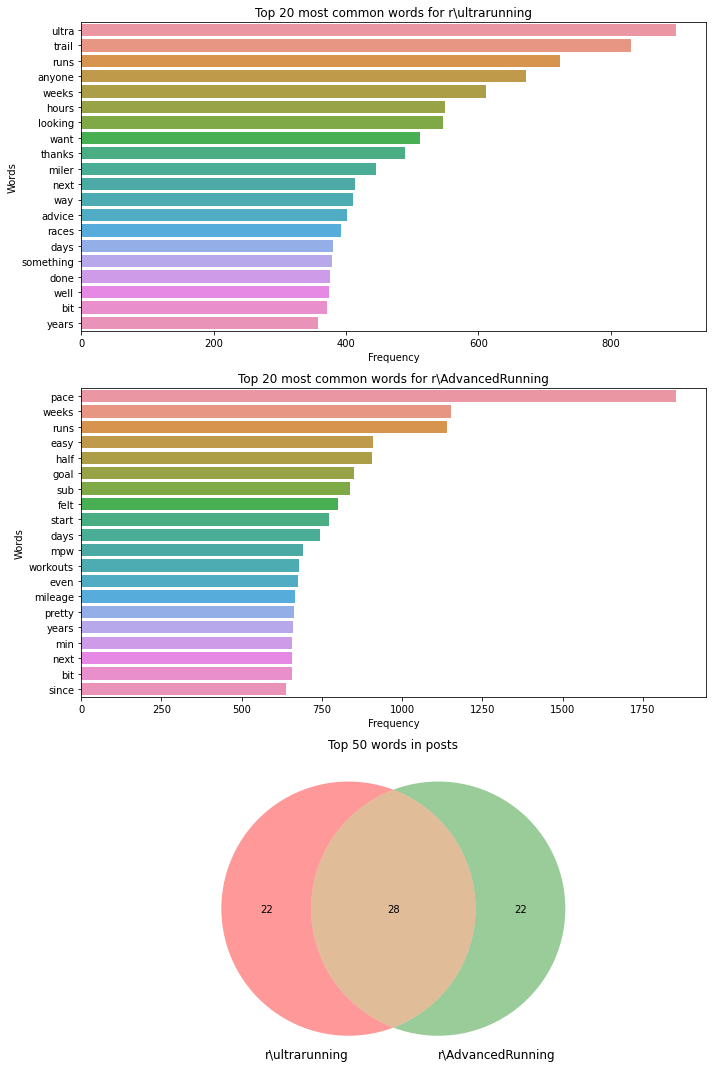

In [99]:
# Check most frequent words after additional stop words 
frequentwords(df, 'cleaned_2', words_to_remove_new)

The result is only marginally better after removing the first 35 most common intersecting words. I still end up with 28 intersecting words. Let's see if this makes Models 4 and 8 better...

#### Create train test set

In [100]:
# Lemmatize after removing more stop words
lemmatizer = WordNetLemmatizer()

df['extreme_cleaned_lemma'] = df['cleaned_3'].map(
    lambda x: [lemmatizer.lemmatize(token) \
               for token in x \
               if token not in words_to_remove_new]
).map(
    lambda x: ' '.join(x)
)

In [101]:
# Create train test sets
X_extreme = df['extreme_cleaned_lemma']
y_extreme = df['target']

X_extreme_train, X_extreme_test, y_extreme_train, y_extreme_test = train_test_split(
    X_extreme, y_extreme,
    stratify = y_extreme,
    random_state = 42
)

In [102]:
# Check
X_extreme_train.shape, X_extreme_test.shape, y_extreme_train.shape, y_extreme_test.shape

((3698,), (1233,), (3698,), (1233,))

#### TfidfVectorizer / Logistic

In [103]:
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logit', LogisticRegression())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'logit__C': [0.1, 1, 10],
    'logit__max_iter': [1_000]
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_extreme_train, X_extreme_test, y_extreme_train, y_extreme_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'logit__C': 1, 'logit__max_iter': 1000, 'tvec__max_df': 0.5, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3)}


In [104]:
# Populate 'Remarks' column
df_results.loc[df_results['Model No.'] == 13, 'Remarks'] = 'Removed 35 intersecting common words, cousin of Model 4'
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Runtime (sec),Remarks
0,1,CountVectorizer(),MultinomialNB(),0.796,0.830,0.783,0.856,0.710,0.749,86,Lemmatized
0,2,TfidfVectorizer(),MultinomialNB(),0.810,0.853,0.788,0.818,0.759,0.774,87,Lemmatized
0,3,CountVectorizer(),LogisticRegression(),0.806,0.920,0.796,0.818,0.773,0.785,94,Lemmatized
0,4,TfidfVectorizer(),LogisticRegression(),0.824,0.899,0.801,0.818,0.785,0.793,87,Lemmatized
0,5,CountVectorizer(),RandomForestClassifier(),0.812,0.999,0.805,0.797,0.814,0.812,530,Lemmatized
0,6,TfidfVectorizer(),RandomForestClassifier(),0.815,0.999,0.785,0.802,0.768,0.778,542,Lemmatized
0,7,CountVectorizer(),ExtraTreesClassifier(),0.815,0.999,0.783,0.756,0.811,0.802,508,Lemmatized
0,8,TfidfVectorizer(),ExtraTreesClassifier(),0.819,0.999,0.794,0.781,0.808,0.804,516,Lemmatized
0,9,TfidfVectorizer(),LogisticRegression(),0.823,0.903,0.810,0.816,0.804,0.808,32,"Stemmatized, cousin of Model 4"
0,10,TfidfVectorizer(),ExtraTreesClassifier(),0.822,0.999,0.793,0.777,0.809,0.805,77,"Stemmatized, cousin of Model 8"


Removal of common intersecting words does not seem to do well. Model performance drops when compared to Model 4. In fact, I noticed that the most optimal ngram_range for Model 13 is (1,3), as compared to the optimal ngram_range of (1,2) for Model 4. This means that the model is 'struggling' to find more words or phrases to do a better fit after I dropped the 35 most common intersecting words. 
Let's see if the same pattern is observed for ExtraTrees.

#### TfidfVectorizer / ExtraTrees

In [105]:
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('et', ExtraTreesClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'et__n_estimators': [100, 200],
    'et__max_depth' : [None]
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_extreme_train, X_extreme_test, y_extreme_train, y_extreme_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'et__max_depth': None, 'et__n_estimators': 200, 'tvec__max_df': 0.5, 'tvec__max_features': 2000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 1)}


In [106]:
# Populate 'Remarks' column
df_results.loc[df_results['Model No.'] == 14, 'Remarks'] = 'Removed 35 intersecting common words, cousin of Model 8'
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Runtime (sec),Remarks
0,1,CountVectorizer(),MultinomialNB(),0.796,0.830,0.783,0.856,0.710,0.749,86,Lemmatized
0,2,TfidfVectorizer(),MultinomialNB(),0.810,0.853,0.788,0.818,0.759,0.774,87,Lemmatized
0,3,CountVectorizer(),LogisticRegression(),0.806,0.920,0.796,0.818,0.773,0.785,94,Lemmatized
0,4,TfidfVectorizer(),LogisticRegression(),0.824,0.899,0.801,0.818,0.785,0.793,87,Lemmatized
0,5,CountVectorizer(),RandomForestClassifier(),0.812,0.999,0.805,0.797,0.814,0.812,530,Lemmatized
0,6,TfidfVectorizer(),RandomForestClassifier(),0.815,0.999,0.785,0.802,0.768,0.778,542,Lemmatized
0,7,CountVectorizer(),ExtraTreesClassifier(),0.815,0.999,0.783,0.756,0.811,0.802,508,Lemmatized
0,8,TfidfVectorizer(),ExtraTreesClassifier(),0.819,0.999,0.794,0.781,0.808,0.804,516,Lemmatized
0,9,TfidfVectorizer(),LogisticRegression(),0.823,0.903,0.810,0.816,0.804,0.808,32,"Stemmatized, cousin of Model 4"
0,10,TfidfVectorizer(),ExtraTreesClassifier(),0.822,0.999,0.793,0.777,0.809,0.805,77,"Stemmatized, cousin of Model 8"


Not surprisingly, removing more intersection words does not work for ExtraTrees too. Perhaps the solution is to remove even MORE intersecting words. Let's see if it works.

#### Obtain intersection of 200 most common words!!

In [107]:
# Find intersecting words
intersect = intersect_words(df, 'cleaned_lemma', 200)

In [108]:
# Check length to make sure function works
len(intersect)

157

There are 157 intersecting words in the top 200 most common words found in the two subreddits.

In [109]:
# Review intersecting words
intersect

['week',
 'time',
 'like',
 'trail',
 'first',
 'would',
 'year',
 'day',
 'get',
 'long',
 'hour',
 'back',
 'km',
 'one',
 'last',
 'run',
 'anyone',
 'really',
 'marathon',
 'plan',
 'much',
 'know',
 'good',
 'feel',
 'also',
 'looking',
 'runner',
 'want',
 'going',
 'month',
 'ran',
 'got',
 'go',
 'thanks',
 'distance',
 'around',
 'could',
 'think',
 'shoe',
 'way',
 'lot',
 'next',
 'two',
 'thing',
 'started',
 'advice',
 'still',
 'foot',
 'race',
 'something',
 'need',
 'start',
 'bit',
 'done',
 'well',
 'work',
 'pace',
 'make',
 'pretty',
 'people',
 'experience',
 'thought',
 'take',
 'road',
 'new',
 'goal',
 'even',
 'right',
 'water',
 'since',
 'finish',
 'felt',
 'half',
 'getting',
 'see',
 'course',
 'help',
 'never',
 'every',
 'little',
 'point',
 'great',
 'pain',
 'minute',
 'keep',
 'question',
 'mileage',
 'better',
 'try',
 'enough',
 'wondering',
 'use',
 'able',
 'hi',
 'issue',
 'sure',
 'leg',
 'went',
 'end',
 'trying',
 'couple',
 'idea',
 'feeling',

#### Remove intersection words

In [110]:
# Round 3: Expand stop word dictionary
words_to_remove_new = words_to_remove + intersect

In [111]:
words_to_remove_new[-50:]

['ago',
 'find',
 'may',
 'etc',
 'made',
 'anything',
 'hill',
 'event',
 'many',
 'another',
 'maybe',
 'past',
 'easy',
 'watch',
 'train',
 'body',
 'guy',
 'currently',
 'without',
 'best',
 'short',
 'tried',
 'probably',
 'due',
 'far',
 'per',
 'hr',
 'post',
 'used',
 'though',
 'might',
 'always',
 'give',
 'starting',
 'took',
 'recently',
 'summer',
 'high',
 'wanted',
 'slow',
 'mi',
 'mpw',
 'hit',
 'second',
 'come',
 'however',
 'put',
 'say',
 'left',
 'rest']

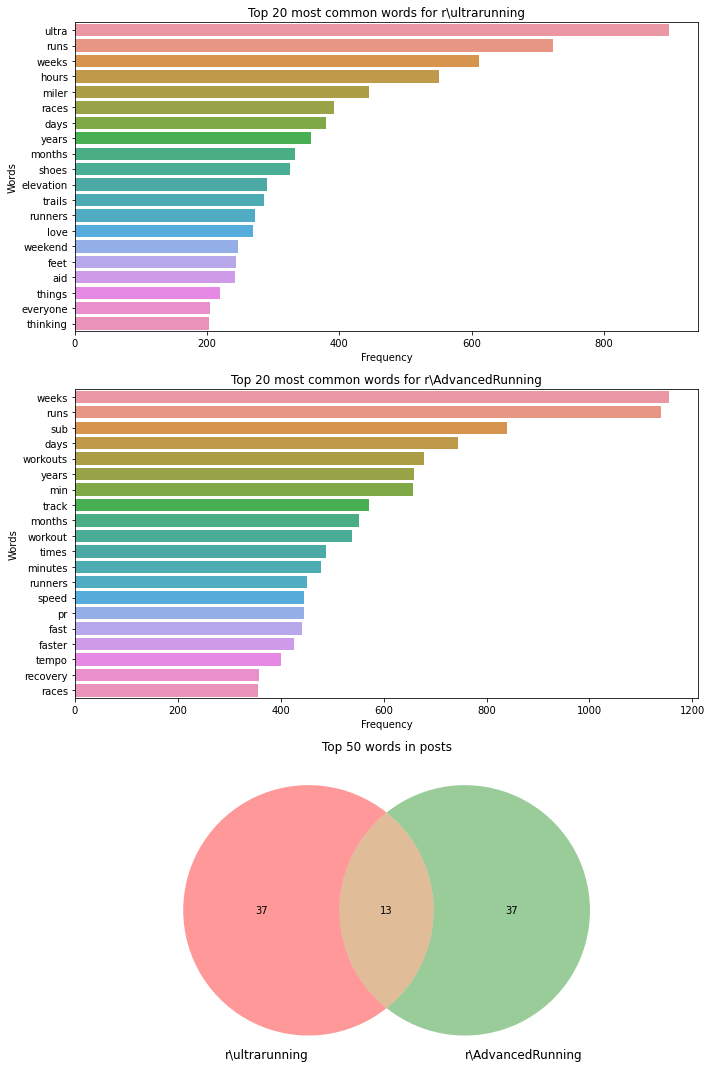

In [112]:
# Check most frequent words after additional stop words 
frequentwords(df, 'cleaned_2', words_to_remove_new)

Out of the top 200 most common words, a staggering 157 words overlap. After removing them, the number of intersecting words in the top 50 drop from 41 to 13. Let's see if this works now.

#### Create train test set

In [113]:
# Lemmatize after removing more stop words
lemmatizer = WordNetLemmatizer()

df['crazy_cleaned_lemma'] = df['cleaned_3'].map(
    lambda x: [lemmatizer.lemmatize(token) \
               for token in x \
               if token not in words_to_remove_new]
).map(
    lambda x: ' '.join(x)
)

In [114]:
# Create train test sets
X_crazy = df['crazy_cleaned_lemma']
y_crazy = df['target']

X_crazy_train, X_crazy_test, y_crazy_train, y_crazy_test = train_test_split(
    X_crazy, y_crazy,
    stratify = y_crazy,
    random_state = 42
)

In [115]:
# Check
X_crazy_train.shape, X_crazy_test.shape, y_crazy_train.shape, y_crazy_test.shape

((3698,), (1233,), (3698,), (1233,))

#### TfidfVectorizer / Logistic

In [116]:
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logit', LogisticRegression())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'logit__C': [0.1, 1, 10],
    'logit__max_iter': [1_000]
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_crazy_train, X_crazy_test, y_crazy_train, y_crazy_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'logit__C': 1, 'logit__max_iter': 1000, 'tvec__max_df': 0.5, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}


In [117]:
# Set wider column width 
pd.set_option('display.max_colwidth', 70)

In [118]:
# Populate 'Remarks' column
df_results.loc[df_results['Model No.'] == 15, 'Remarks'] = 'Removed 157 intersecting common words, cousin of Model 4'
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Runtime (sec),Remarks
0,1,CountVectorizer(),MultinomialNB(),0.796,0.830,0.783,0.856,0.710,0.749,86,Lemmatized
0,2,TfidfVectorizer(),MultinomialNB(),0.810,0.853,0.788,0.818,0.759,0.774,87,Lemmatized
0,3,CountVectorizer(),LogisticRegression(),0.806,0.920,0.796,0.818,0.773,0.785,94,Lemmatized
0,4,TfidfVectorizer(),LogisticRegression(),0.824,0.899,0.801,0.818,0.785,0.793,87,Lemmatized
0,5,CountVectorizer(),RandomForestClassifier(),0.812,0.999,0.805,0.797,0.814,0.812,530,Lemmatized
0,6,TfidfVectorizer(),RandomForestClassifier(),0.815,0.999,0.785,0.802,0.768,0.778,542,Lemmatized
0,7,CountVectorizer(),ExtraTreesClassifier(),0.815,0.999,0.783,0.756,0.811,0.802,508,Lemmatized
0,8,TfidfVectorizer(),ExtraTreesClassifier(),0.819,0.999,0.794,0.781,0.808,0.804,516,Lemmatized
0,9,TfidfVectorizer(),LogisticRegression(),0.823,0.903,0.810,0.816,0.804,0.808,32,"Stemmatized, cousin of Model 4"
0,10,TfidfVectorizer(),ExtraTreesClassifier(),0.822,0.999,0.793,0.777,0.809,0.805,77,"Stemmatized, cousin of Model 8"


Removing a crazy amount of overlapping words (157!) improved test score over Model 13 (which removed 35 words). Let's test it out for ExtraTrees.

#### TfidfVectorizer / ExtraTrees

In [119]:
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('et', ExtraTreesClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'et__n_estimators': [100, 200],
    'et__max_depth' : [None]
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_crazy_train, X_crazy_test, y_crazy_train, y_crazy_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'et__max_depth': None, 'et__n_estimators': 200, 'tvec__max_df': 0.5, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}


In [120]:
# Populate 'Remarks' column
df_results.loc[df_results['Model No.'] == 16, 'Remarks'] = 'Removed 157 intersecting common words, cousin of Model 8'
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Runtime (sec),Remarks
0,1,CountVectorizer(),MultinomialNB(),0.796,0.830,0.783,0.856,0.710,0.749,86,Lemmatized
0,2,TfidfVectorizer(),MultinomialNB(),0.810,0.853,0.788,0.818,0.759,0.774,87,Lemmatized
0,3,CountVectorizer(),LogisticRegression(),0.806,0.920,0.796,0.818,0.773,0.785,94,Lemmatized
0,4,TfidfVectorizer(),LogisticRegression(),0.824,0.899,0.801,0.818,0.785,0.793,87,Lemmatized
0,5,CountVectorizer(),RandomForestClassifier(),0.812,0.999,0.805,0.797,0.814,0.812,530,Lemmatized
0,6,TfidfVectorizer(),RandomForestClassifier(),0.815,0.999,0.785,0.802,0.768,0.778,542,Lemmatized
0,7,CountVectorizer(),ExtraTreesClassifier(),0.815,0.999,0.783,0.756,0.811,0.802,508,Lemmatized
0,8,TfidfVectorizer(),ExtraTreesClassifier(),0.819,0.999,0.794,0.781,0.808,0.804,516,Lemmatized
0,9,TfidfVectorizer(),LogisticRegression(),0.823,0.903,0.810,0.816,0.804,0.808,32,"Stemmatized, cousin of Model 4"
0,10,TfidfVectorizer(),ExtraTreesClassifier(),0.822,0.999,0.793,0.777,0.809,0.805,77,"Stemmatized, cousin of Model 8"


Removing a crazy amount of words (157!) does not seem to work for ExtraTrees. It degrades performance throughout. 

Bottom line, I think that removing more common words that overlap in the two subreddit communities, be it a little bit (35 words) or a lot (157 words) does not help improve model performance.

### Join Title to Selftext

One final attempt is to try to push beyond the project's remit of analyzing subreddit text only. I shall try to "create" more data by joining a post's title to its text, even though the title typically consists of much fewer words than its text. Perhaps I may be able to push accuracy beyond 0.60...

#### Clean title column

In [121]:
# Remove URLs
df['title_cleaned'] = df['title'].map(
    lambda x: re.sub(r'http\S+', '', x)
)

# Remove the %ampersand term
df['title_cleaned'] = df['title_cleaned'].map(
    lambda x: x.replace('&amp;#x200B;', ' ') 
)

# Extract words only    
df['title_cleaned'] = df['title_cleaned'].map(
    lambda x: re.sub('[^a-zA-Z]', ' ', x)
)

# Remove stop words and lemmatize
lemmatizer = WordNetLemmatizer()

df['title_cleaned'] = df['title_cleaned'].map(lambda x: x.lower().split())

df['title_cleaned'] = df['title_cleaned'].map(
    lambda x: [lemmatizer.lemmatize(token) \
               for token in x \
               if token not in words_to_remove
              ]
).map(
    lambda x: ' '.join(x)
)

In [122]:
df[['title', 'title_cleaned']].sample(5)

,title,title_cleaned
3179,Rento Canova's Marathon Training Methods PDF,rento canova marathon method pdf
4860,Additional training; HS XC athlete,additional h xc athlete
4436,Sub 4 Marathon Plan,sub marathon plan
1016,Blood in Urine,blood urine
3988,Question about Daniel’s Running Formula,question daniel formula


#### Create train test split

In [123]:
# Join lemmatized title to lemmatized selftext
#   then create train_test_split

X_joint = df['title_cleaned'] + df['cleaned_lemma']
y_joint = df['target']

X_joint_train, X_joint_test, y_joint_train, y_joint_test = train_test_split(
    X_joint, y_joint,
    stratify = y_joint,
    random_state = 42
)

In [124]:
# Check
X_joint_train.shape, X_joint_test.shape, y_joint_train.shape, y_joint_test.shape

((3698,), (1233,), (3698,), (1233,))

In [125]:
# Count new number of words

print(f"The original total word count is {df['word_count'].sum()}.")
print(f"Total word count after lemmatization is {np.sum([len(x.split()) for x in df['cleaned_lemma']])}.")
print(f"Total word count after combining title and selftext is {np.sum([len(x.split()) for x in df['title_cleaned'] + df['cleaned_lemma']])}.")

The original total word count is 889620.
Total word count after lemmatization is 407845.
Total word count after combining title and selftext is 424685.


In [126]:
424685 - 407845, 424685/407845-1

(16840, 0.041290196030354664)

I gain another 16,840 words (or 4% more)to feed into my classification models. Not a lot, but worth a try.

#### TfidfVectorizer / Logistic

In [127]:
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logit', LogisticRegression())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'logit__C': [0.1, 1, 10],
    'logit__max_iter': [1_000]
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_joint_train, X_joint_test, y_joint_train, y_joint_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'logit__C': 1, 'logit__max_iter': 1000, 'tvec__max_df': 0.5, 'tvec__max_features': 2000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 2)}


In [128]:
# Populate 'Remarks' column
df_results.loc[df_results['Model No.'] == 17, 'Remarks'] = 'Combine title and selftext, cousin of Model 4'
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Runtime (sec),Remarks
0,1,CountVectorizer(),MultinomialNB(),0.796,0.830,0.783,0.856,0.710,0.749,86,Lemmatized
0,2,TfidfVectorizer(),MultinomialNB(),0.810,0.853,0.788,0.818,0.759,0.774,87,Lemmatized
0,3,CountVectorizer(),LogisticRegression(),0.806,0.920,0.796,0.818,0.773,0.785,94,Lemmatized
0,4,TfidfVectorizer(),LogisticRegression(),0.824,0.899,0.801,0.818,0.785,0.793,87,Lemmatized
0,5,CountVectorizer(),RandomForestClassifier(),0.812,0.999,0.805,0.797,0.814,0.812,530,Lemmatized
0,6,TfidfVectorizer(),RandomForestClassifier(),0.815,0.999,0.785,0.802,0.768,0.778,542,Lemmatized
0,7,CountVectorizer(),ExtraTreesClassifier(),0.815,0.999,0.783,0.756,0.811,0.802,508,Lemmatized
0,8,TfidfVectorizer(),ExtraTreesClassifier(),0.819,0.999,0.794,0.781,0.808,0.804,516,Lemmatized
0,9,TfidfVectorizer(),LogisticRegression(),0.823,0.903,0.810,0.816,0.804,0.808,32,"Stemmatized, cousin of Model 4"
0,10,TfidfVectorizer(),ExtraTreesClassifier(),0.822,0.999,0.793,0.777,0.809,0.805,77,"Stemmatized, cousin of Model 8"


This works! Merging title and body content improves performance throughout, when compared to the original verion Model 4. Let's try it out for ExtraTrees.

#### TfidfVectorizer / ExtraTrees

In [129]:
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('et', ExtraTreesClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'et__n_estimators': [100, 200],
    'et__max_depth' : [None]
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_joint_train, X_joint_test, y_joint_train, y_joint_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'et__max_depth': None, 'et__n_estimators': 200, 'tvec__max_df': 0.5, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3)}


In [130]:
# Populate 'Remarks' column
df_results.loc[df_results['Model No.'] == 18, 'Remarks'] = 'Combine title and selftext, cousin of Model 8'
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Runtime (sec),Remarks
0,1,CountVectorizer(),MultinomialNB(),0.796,0.830,0.783,0.856,0.710,0.749,86,Lemmatized
0,2,TfidfVectorizer(),MultinomialNB(),0.810,0.853,0.788,0.818,0.759,0.774,87,Lemmatized
0,3,CountVectorizer(),LogisticRegression(),0.806,0.920,0.796,0.818,0.773,0.785,94,Lemmatized
0,4,TfidfVectorizer(),LogisticRegression(),0.824,0.899,0.801,0.818,0.785,0.793,87,Lemmatized
0,5,CountVectorizer(),RandomForestClassifier(),0.812,0.999,0.805,0.797,0.814,0.812,530,Lemmatized
0,6,TfidfVectorizer(),RandomForestClassifier(),0.815,0.999,0.785,0.802,0.768,0.778,542,Lemmatized
0,7,CountVectorizer(),ExtraTreesClassifier(),0.815,0.999,0.783,0.756,0.811,0.802,508,Lemmatized
0,8,TfidfVectorizer(),ExtraTreesClassifier(),0.819,0.999,0.794,0.781,0.808,0.804,516,Lemmatized
0,9,TfidfVectorizer(),LogisticRegression(),0.823,0.903,0.810,0.816,0.804,0.808,32,"Stemmatized, cousin of Model 4"
0,10,TfidfVectorizer(),ExtraTreesClassifier(),0.822,0.999,0.793,0.777,0.809,0.805,77,"Stemmatized, cousin of Model 8"


As the saying goes, more data is good! Models 17 and 18 are improvements over Models 4 and 8, with mean CV scores increasing from (0.824 to 0.834) and (0.819 to 0.830) respectively, and test scores increasing from (0.801 to 0.815) and (0.801 to 0.809) respectively.

Early on, it was a bit hard to decide between Model 4 and Model 8 as they have similar test scores. However, with this additional piece of feature engineering, Model 17 is the clear winner as it has higher CV and test scores over Model 18. Model 18 also suffers from overfitting as its train score is near-perfect at 0.999, so I would place less credibility on it since the parameters are so tuned on this specific train set that it is unlikely to do well on new test sets in future.

## Tuning hyperparameters

Now that I have selected Model 17 as my prefered model, let's look at further tuning the hyperparameters. Grid searches take a long time for me to run, so let's see if we can further expand the range of parameters to search in a more logical way.

The parameters fed to the initial gridsearch are: 
- 'tvec__min_df': \[1, 2\]
- 'tvec__max_df': \[.1, .5, 1\]
- 'tvec__max_features' : \[1000, 2000\]
- 'tvec__ngram_range': \[(1,1), (1,2), (1,3)\]
- 'logit__C': \[0.1, 1, 10\]
- 'logit__max_iter': \[1_000\] 

The best parameters from the initial run are:
- 'tvec__min_df': 2
- 'tvec__max_df': 0.5
- 'tvec__max_features': 2000
- 'tvec__ngram_range': (1, 2)
- 'logit__C': 1
- 'logit__max_iter': 1000

New parameters to run GridSearchCV on: 
- 'tvec__min_df': By process of elimination, I do not need to run min_df = 1 anymore, but I should probably try if I should set the min number docs to be 3 or 4 to see if that is preferred by the model.  
- 'tvec__max_df': 0.1 and 1.0 were rejected while 0.5 was picked, so the optimal X% of documents should lie between 0.1 and 1.0. Let me try 0.25, 0.5, 0.75 next.
- 'tvec__max_features': It sounds like the model wants to act on more word features, so I will add 3000 and 4000 to the search.
- 'tvec__ngram_range': (1, 2) lies between (1,1) and (1,3) and it was picked, so i do not need to further tune this hyperparameter.
- 'logit__C': Looks like the optimal C lies between 0.1 and 10, so I will create a few more options to search on - 0.25, 0.5, 1, 1.5, 2 
- 'logit__max_iter': This is a free lunch if time is available, so I shall increase # of interations from 1_000 to 10_000

This is going to take a while to run...let me make some coffee.

#### Tuning - Round One

In [131]:
%%time 
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logit', LogisticRegression())
])

# Set parameters
params = {
    'tvec__min_df': [2, 3, 4],
    'tvec__max_df': [0.25, 0.5, 0.75],
    'tvec__max_features' : [2000, 3000, 4000],
    'tvec__ngram_range': [(1,2)],
    'logit__C': [0.25, 0.5, 1, 1.5, 2],
    'logit__max_iter': [10_000]
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_joint_train, X_joint_test, y_joint_train, y_joint_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best Parameters: {'logit__C': 1.5, 'logit__max_iter': 10000, 'tvec__max_df': 0.5, 'tvec__max_features': 4000, 'tvec__min_df': 4, 'tvec__ngram_range': (1, 2)}
CPU times: user 3.84 s, sys: 349 ms, total: 4.19 s
Wall time: 1min 55s


In [132]:
# Populate 'Remarks' column
df_results.loc[df_results['Model No.'] == 19, 'Remarks'] = 'Model 17, but with more hyperparameters to search on'
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Runtime (sec),Remarks
0,1,CountVectorizer(),MultinomialNB(),0.796,0.830,0.783,0.856,0.710,0.749,86,Lemmatized
0,2,TfidfVectorizer(),MultinomialNB(),0.810,0.853,0.788,0.818,0.759,0.774,87,Lemmatized
0,3,CountVectorizer(),LogisticRegression(),0.806,0.920,0.796,0.818,0.773,0.785,94,Lemmatized
0,4,TfidfVectorizer(),LogisticRegression(),0.824,0.899,0.801,0.818,0.785,0.793,87,Lemmatized
0,5,CountVectorizer(),RandomForestClassifier(),0.812,0.999,0.805,0.797,0.814,0.812,530,Lemmatized
0,6,TfidfVectorizer(),RandomForestClassifier(),0.815,0.999,0.785,0.802,0.768,0.778,542,Lemmatized
0,7,CountVectorizer(),ExtraTreesClassifier(),0.815,0.999,0.783,0.756,0.811,0.802,508,Lemmatized
0,8,TfidfVectorizer(),ExtraTreesClassifier(),0.819,0.999,0.794,0.781,0.808,0.804,516,Lemmatized
0,9,TfidfVectorizer(),LogisticRegression(),0.823,0.903,0.810,0.816,0.804,0.808,32,"Stemmatized, cousin of Model 4"
0,10,TfidfVectorizer(),ExtraTreesClassifier(),0.822,0.999,0.793,0.777,0.809,0.805,77,"Stemmatized, cousin of Model 8"


I see an improvement by tuning the hyperparameters, with mean CV score improving by 0.06 (0.834 to 0.840) and test score improving by 0.05 (0.815 to 0.820). Not a big improvement, but maybe it's worth one more round of tuning. Let's analyse the best parameters and see what we can do.

The best parameters between the first and second run have changed as follow:
- 'tvec__min_df': 2 -> 4
- 'tvec__max_df': 0.5 -> 0.5
- 'tvec__max_features': 2000 -> 4000
- 'tvec__ngram_range': (1, 2)
- 'logit__C': 1 -> 1.5
- 'logit__max_iter': 1000 -> 10000

Comments: 
- 'tvec__min_df': It looks like the model yearns for a higher min_df for the vectorizer. I will run an even wider range - 4, 6, 8, 10.
- 'tvec__max_df': 0.5 was picked again. Let's narrow the range from (0.25, 0.5, 0.75) to (0.4, 0.5, 0.6).
- 'tvec__max_features': It sounds like the model wants even more word features, so let's do 4000, 6000, 8000, 10_000.
- 'tvec__ngram_range': Leave as (1,2).
- 'logit__C': The model picked a new value 1.5, so it wants a stronger regularisation. Let's narrow the range further to see if closer values make a difference - 1.3, 1.4, 1.5, 1.6, 1.7.
- 'logit__max_iter': Leave as 10_000.


#### Tuning - Round Two

In [133]:
%%time 
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logit', LogisticRegression())
])

# Set parameters
params = {
    'tvec__min_df': [4, 6, 8, 10],
    'tvec__max_df': [0.4, 0.5, 0.6],
    'tvec__max_features' : [4000, 6000, 8000, 10_000],
    'tvec__ngram_range': [(1,2)],
    'logit__C': [1.3, 1.4, 1.5, 1.6, 1.7],
    'logit__max_iter': [10_000]
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_joint_train, X_joint_test, y_joint_train, y_joint_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best Parameters: {'logit__C': 1.5, 'logit__max_iter': 10000, 'tvec__max_df': 0.4, 'tvec__max_features': 4000, 'tvec__min_df': 4, 'tvec__ngram_range': (1, 2)}
CPU times: user 5.66 s, sys: 599 ms, total: 6.26 s
Wall time: 3min 22s


In [134]:
# Populate 'Remarks' column
df_results.loc[df_results['Model No.'] == 20, 'Remarks'] = 'Model 17, final round of tuning of hyperparameters'
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Runtime (sec),Remarks
0,1,CountVectorizer(),MultinomialNB(),0.796,0.830,0.783,0.856,0.710,0.749,86,Lemmatized
0,2,TfidfVectorizer(),MultinomialNB(),0.810,0.853,0.788,0.818,0.759,0.774,87,Lemmatized
0,3,CountVectorizer(),LogisticRegression(),0.806,0.920,0.796,0.818,0.773,0.785,94,Lemmatized
0,4,TfidfVectorizer(),LogisticRegression(),0.824,0.899,0.801,0.818,0.785,0.793,87,Lemmatized
0,5,CountVectorizer(),RandomForestClassifier(),0.812,0.999,0.805,0.797,0.814,0.812,530,Lemmatized
0,6,TfidfVectorizer(),RandomForestClassifier(),0.815,0.999,0.785,0.802,0.768,0.778,542,Lemmatized
0,7,CountVectorizer(),ExtraTreesClassifier(),0.815,0.999,0.783,0.756,0.811,0.802,508,Lemmatized
0,8,TfidfVectorizer(),ExtraTreesClassifier(),0.819,0.999,0.794,0.781,0.808,0.804,516,Lemmatized
0,9,TfidfVectorizer(),LogisticRegression(),0.823,0.903,0.810,0.816,0.804,0.808,32,"Stemmatized, cousin of Model 4"
0,10,TfidfVectorizer(),ExtraTreesClassifier(),0.822,0.999,0.793,0.777,0.809,0.805,77,"Stemmatized, cousin of Model 8"


Despite expanding the range of hyperparameter values to test on, only one hyperparameter was changed: tvec__max_df from 0.5 to 0.4. All other hyperparameters did not want to change. As such, the test scores, train scores and 5-fold CV scores are unchanged. This suggests that I probably can't push my model any further. Model 20 is the final selection!

## Final model

### Understanding model performance

Test score (aka Accuracy): 0.820
Sensitivity: 0.818, Specificity: 0.822, Precision: 0.823


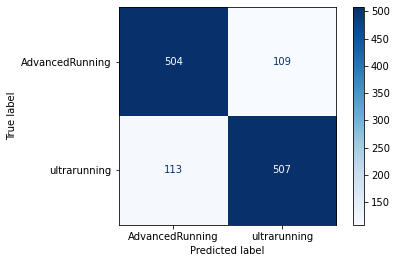

In [135]:
# Create and fit final selected model

pipe = Pipeline([
    ('tvec', TfidfVectorizer(
        min_df = 4,
        max_df = 0.4,
        max_features = 4000,
        ngram_range = (1, 2)
        )
    ),
    ('logit', LogisticRegression(
        C = 1.5,
        max_iter = 10_000
        )
    )
])

pipe.fit(X_joint_train, y_joint_train)

# Confusion matrix
y_pred = pipe.predict(X_joint_test)
tn, fp, fn, tp = confusion_matrix(y_joint_test, y_pred).ravel()

plot_confusion_matrix(pipe, 
                      X_joint_test, y_joint_test, 
                      cmap='Blues', 
                      values_format='d', 
                      display_labels=[subreddit2, subreddit1]
                     );
# Print results
print(f'Test score (aka Accuracy): {pipe.score(X_joint_test, y_joint_test):.3f}')
print(f'Sensitivity: {tp/(tp+fn):.3f}, Specificity: {tn/(tn+fp):.3f}, Precision: {tp/(tp+fp):.3f}')


My model has an accuracy of 82%. Out of 1233 posts in the test set, it got 1011 correct, i.e. assigning reddit posts to r\AdvancedRunning and r\ultrarunning correctly. Only 18% of posts are misclassified.

It also seems to be equally good in predicting r\AdvancedRunning posts \[504 / (504+109)\] = 82.2% = specificity, as it is in predicting r\ultrarunning posts \[507/(507+113)\] = 81.8% = sensitivity (I had arbitrarily set r\ultrarunning as "1" and r\AdvancedRunning as "0" earlier on). 

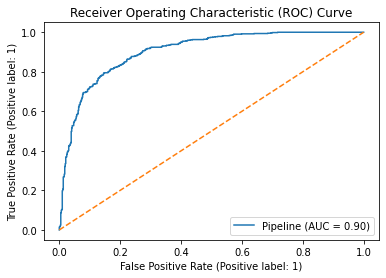

In [136]:
# ROC curve
plot_roc_curve(pipe, X_joint_test, y_joint_test)

# add worst case scenario line
plt.plot([0,1], [0,1], label = "baseline", linestyle = "--")

# add title
plt.title('Receiver Operating Characteristic (ROC) Curve');

I have an ROC score of 0.9 which is a pretty respectable score (perfect score is 1.0, worst is 0.5). The ROC curve plots the highest true positive rate (r\ultrarunning) together with the lowest false positive rate (predicting r\ultrarunning when it actually belongs to r\AdvanceRunning). 

Let's look at what are the word features that give us a decent prediction capability.

### Features of importance

In [137]:
# Obtain coefficients from logit model
coef = pipe.named_steps['logit'].coef_.flatten()

In [138]:
# Obtain feature names from TF-IDF vectorizer
features = pipe.named_steps['tvec'].get_feature_names()

In [139]:
# Check length = 4000 as defined during model fitting
len(coef), len(features)

(4000, 4000)

In [140]:
# Create dataframe of features and their coefficients
df_coef = pd.DataFrame(zip(features, coef), 
                       columns = ["Features", "Coefficient"]
                      ).sort_values('Coefficient', 
                                    ascending = False)

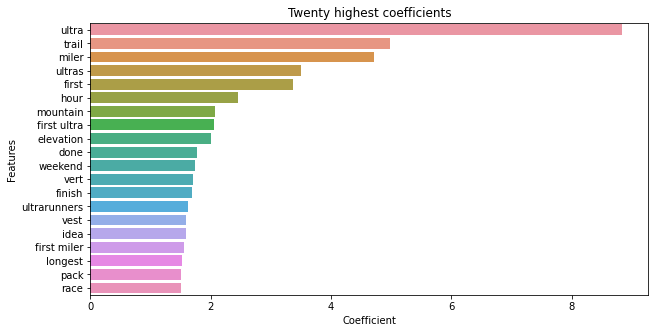

In [141]:
# Plot 20 highest coefficients
plt.figure(figsize=(10,5))
ax = sns.barplot(x = 'Coefficient', y = 'Features', data = df_coef.head(20))
ax.set_title(f"Twenty highest coefficients")
ax.set_xlabel("Coefficient")
ax.set_ylabel("Features");

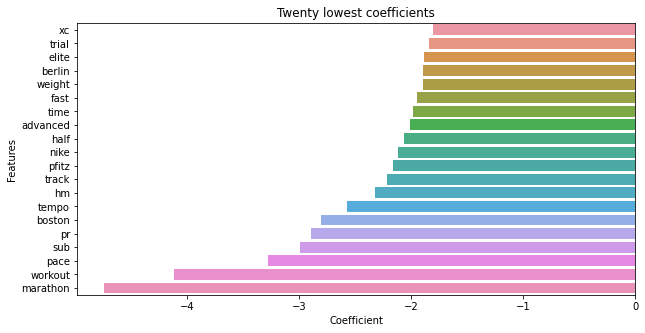

In [142]:
# Plot 20 lowest coefficients
plt.figure(figsize=(10,5))
ax = sns.barplot(x = 'Coefficient', y = 'Features', data = df_coef.tail(20))
ax.set_title(f"Twenty lowest coefficients")
ax.set_xlabel("Coefficient")
ax.set_ylabel("Features");

The way to interpret these coeffcients is that the odds of landing a "1" which is r\ultrarunning is higher for positive coefficients, and the odds of landing a "0" which is r\AdvancedRunning is higher for negative coefficients.

As the features are regressed on log(odds), the way to convert the coeffficients is to take its nature exponential, i.e. np.exp().

While I am not surprised to see words such as 'ultra' and 'ultras' listed for features that predict r\ultrarunning, I am surprised to see words such as 'trail', 'mountain' and 'elevation' listed. This suggests that runners who tend to like to run in natural surroundings instead of road flock to r\ultrarunning.

For r\AdvancedRunning, I am surprised to see words such as 'workout', 'pace', 'sub', tempo', 'fast' listed as features that predict r\AdvancedRunning. It suggests that this community is perhaps more serious about training-related matters!

For my problem statement, it sounds like I should probably post my questions on r\AdvancedRunning!

In [143]:
df_coef.head(20)

,Features,Coefficient
3644,ultra,8.834113
3564,trail,4.973451
2105,miler,4.721215
3656,ultras,3.494677
1149,first,3.374346
1553,hour,2.453725
2173,mountain,2.071855
1167,first ultra,2.055827
928,elevation,1.999726
855,done,1.774507


In [144]:
df_coef.tail(20)

,Features,Coefficient
3955,xc,-1.808039
3588,trial,-1.837832
932,elite,-1.887763
332,berlin,-1.891835
3843,weight,-1.896120
1068,fast,-1.950791
3472,time,-1.985386
54,advanced,-2.012417
1420,half,-2.060819
2287,nike,-2.113261


### Misclassification analysis

In [145]:
# Create DataFrame of predicated values and actual values
results = pd.DataFrame(
    zip(y_joint_test, pipe.predict(X_joint_test)),
    columns = ['actual', 'predicted']
)

In [146]:
# Check
results['title_n_text'] = X_joint_test.reset_index(drop = True)

In [147]:
# Find all index values where predicted and true results 
# aren't the same, then save in an array.
results = results[results.actual != results.predicted]

In [148]:
# Check if there is anything weird in the title and text body for misclassified posts
pd.set_option('display.max_colwidth', None)
results.sample(5)

,actual,predicted,title_n_text
652,0,1,favorite elite follownearly year anyone expected seen fairly different storyline emerge seen known name fail newer name emerge favorite follow year solly seidel idea prior trail loved way ran atlanta fun ig follow blending great sense humor cool insight
680,1,0,typical lose weight ultramarathonx x made seems like burned hell lot calorie maybe even two pound weight loss habit weighing measure fitness curious possible came pound heavier despite none refueling even amount burned leg pacing le apple orange banana l water electrolyte half scoop protein g rest hour next repeat measured fat caliper went little bit would expect curious gained weight retained water muscle swelling tl dr first time ultra wondering biology physic energy use body mass expect gain lb mass
1142,1,0,u artc made tribute walmsley tune ke ha please enjoycheck help u publicize trial saturday lyric tune tik tok wake morning feeling like jim walmsley grab shoe door gonna hit valley leave wrap knee bunch k tape gonna k gonna great talking nut butter toe toe hoka make clothes clothes calling bros bros speed working hitting pr interview irunfar tryna become road starrrrrr stop lot put oatmeal pot tonight imma grind till see sun shine tick tock clock breaking hour yeah x got care world wanna go japan got marathon pocket plan dude lining saying aint got swagger meet em atlanta cause aint sandbagger talking errbody hard hard boy tryin break c r get close imma pull card card goin till cross line line rd shut u rd shut r shut stop lot put oatmeal pot tonight imma grind till see sun shine tick tock clock breaking hour yeah x real fast blast leg pounded sore real fast blast leg pounded sore
79,1,0,partnerlooking partner rockford illinois area
203,0,1,tracker samsung watchstrava cutting accuracy samsung watch anyone reliable app would recommend


After refreshing the sample function a few times, I still can't seem to find any pattern to misclassified posts based on their title and body content.. Initially, I was suspecting low word count as the reason for misclassification, but it seems like most misclassfied posts are quite verbose.

## Boosting (learnt this after I finished most of the work above...)

Today, I learnt about AdaBoosting in class and I read an XGBoost article sent by Jireh on Slack. These work best on weak classifiers such as DecisionTree with stump (i.e. max_depth = 1) rather than RandomForest. Let me try it out.

In [156]:
%%time
# Run AdaBoost

# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('ada', AdaBoostClassifier(
        base_estimator = DecisionTreeClassifier(max_depth=1),
        n_estimators = 200
    ))
])

# Set parameters
params = {
    'tvec__min_df': [4],
    'tvec__max_df': [0.4],
    'tvec__max_features' : [4000],
    'tvec__ngram_range': [(1,2)],
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_joint_train, X_joint_test, y_joint_train, y_joint_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'tvec__max_df': 0.4, 'tvec__max_features': 4000, 'tvec__min_df': 4, 'tvec__ngram_range': (1, 2)}
CPU times: user 5.88 s, sys: 136 ms, total: 6.01 s
Wall time: 11.9 s


In [157]:
# Populate 'Remarks' column
df_results.loc[df_results['Model No.'] == 21, 'Word Vectorizer'] = 'TfidfVectorizer()'
df_results.loc[df_results['Model No.'] == 21, 'Classifier'] = 'AdaBoost-DecisionTree'
df_results.loc[df_results['Model No.'] == 21, 'Remarks'] = 'Cousin of Model 20'
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Runtime (sec),Remarks
0,1,CountVectorizer(),MultinomialNB(),0.796,0.830,0.783,0.856,0.710,0.749,86,Lemmatized
0,2,TfidfVectorizer(),MultinomialNB(),0.810,0.853,0.788,0.818,0.759,0.774,87,Lemmatized
0,3,CountVectorizer(),LogisticRegression(),0.806,0.920,0.796,0.818,0.773,0.785,94,Lemmatized
0,4,TfidfVectorizer(),LogisticRegression(),0.824,0.899,0.801,0.818,0.785,0.793,87,Lemmatized
0,5,CountVectorizer(),RandomForestClassifier(),0.812,0.999,0.805,0.797,0.814,0.812,530,Lemmatized
...,...,...,...,...,...,...,...,...,...,...,...
0,17,TfidfVectorizer(),LogisticRegression(),0.834,0.908,0.815,0.808,0.822,0.821,36,"Combine title and selftext, cousin of Model 4"
0,18,TfidfVectorizer(),ExtraTreesClassifier(),0.832,0.999,0.812,0.794,0.830,0.826,79,"Combine title and selftext, cousin of Model 8"
0,19,TfidfVectorizer(),LogisticRegression(),0.840,0.927,0.820,0.818,0.822,0.823,115,"Model 17, but with more hyperparameters to search on"
0,20,TfidfVectorizer(),LogisticRegression(),0.840,0.927,0.820,0.818,0.822,0.823,202,"Model 17, final round of tuning of hyperparameters"


In [158]:
%%time
# Run XGBoost

# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('xg', XGBClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [4],
    'tvec__max_df': [0.4],
    'tvec__max_features' : [4000],
    'tvec__ngram_range': [(1,2)],
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_joint_train, X_joint_test, y_joint_train, y_joint_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[22:18:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parameters: {'tvec__max_df': 0.4, 'tvec__max_features': 4000, 'tvec__min_df': 4, 'tvec__ngram_range': (1, 2)}
CPU times: user 10.9 s, sys: 94 ms, total: 11 s
Wall time: 8.97 s


In [159]:
# Populate 'Remarks' column
df_results.loc[df_results['Model No.'] == 22, 'Word Vectorizer'] = 'TfidfVectorizer()'
df_results.loc[df_results['Model No.'] == 22, 'Classifier'] = 'XGBoost-DecisionTree'
df_results.loc[df_results['Model No.'] == 22, 'Remarks'] = 'Cousin of Model 20'
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Runtime (sec),Remarks
0,1,CountVectorizer(),MultinomialNB(),0.796,0.830,0.783,0.856,0.710,0.749,86,Lemmatized
0,2,TfidfVectorizer(),MultinomialNB(),0.810,0.853,0.788,0.818,0.759,0.774,87,Lemmatized
0,3,CountVectorizer(),LogisticRegression(),0.806,0.920,0.796,0.818,0.773,0.785,94,Lemmatized
0,4,TfidfVectorizer(),LogisticRegression(),0.824,0.899,0.801,0.818,0.785,0.793,87,Lemmatized
0,5,CountVectorizer(),RandomForestClassifier(),0.812,0.999,0.805,0.797,0.814,0.812,530,Lemmatized
...,...,...,...,...,...,...,...,...,...,...,...
0,18,TfidfVectorizer(),ExtraTreesClassifier(),0.832,0.999,0.812,0.794,0.830,0.826,79,"Combine title and selftext, cousin of Model 8"
0,19,TfidfVectorizer(),LogisticRegression(),0.840,0.927,0.820,0.818,0.822,0.823,115,"Model 17, but with more hyperparameters to search on"
0,20,TfidfVectorizer(),LogisticRegression(),0.840,0.927,0.820,0.818,0.822,0.823,202,"Model 17, final round of tuning of hyperparameters"
0,21,TfidfVectorizer(),AdaBoost-DecisionTree,0.780,0.916,0.790,0.802,0.778,0.785,11,Cousin of Model 20


My foray with two boosting techniques didn't go well. While XGBoost gives higher CV score than AdaBoost (0.812 vs 0.780) and higher test score than AdaBoost (0.797 vs 0.790), it still underperforms Model 20 by a fair bit.

This seems to imply that more complicated or more in-vogue models do not necessary go well on some datasets that are possibly well-behaved or well-cleaned.

## Conclusion

Before the project started, I naively thought that well-regarded models in Kaggle contests such as RandomForest would do the best. I am pleasantly surprised to see that a simple model such as Logistic Regression would outpeform something more complicated like Multinomial Naive Bayes. When it didn't, my thought is that the independence condition among word features is probably grossly violated since real data sets are never perfectly independent, so it can't perform as well. A [paper](http://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf) by [Andrew Ng](https://en.wikipedia.org/wiki/Andrew_Ng) (we watched one of his videos in class) and [Michael Jordan](https://en.wikipedia.org/wiki/Michael_I._Jordan) (Andrew's PhD advisor, not the Chicago Bulls legend) states that logistic regression should perform better than Naive Bayes as training size gets larger, though I am not sure if my sample size is considered 'large' enough.

I am also pleasantly surprised to see that RandomForest and even popular techniques such as XGBoost couldn't outperform Logistic Regression. I can't find any papers online to explain why this is the case, but the old-fashioned person in me instinctively says that if I can achieve the same results using a simple and easy-to-understand model, we should go for it as it reduces the risks of overfitting and it is easier to dissect if things go wrong.

